State Farm Distracted Drivers
=============

Prev Exercises: Udacity:DeepLearning:TensorFlow:notMNIST  

Fit Multi Layer Perceptron (MLP) with Rectified Linear Units (RELUs) SGD using TensorFlow package
------------

In [1]:
import sys
print sys.version
import os

import pandas as pd
print 'pd.__version__:%s' % str(pd.__version__)
import tensorflow as tf
print 'tf.__version__:%s' % str(tf.__version__)

2.7.11 (default, Jan 28 2016, 14:07:46) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.2 (clang-700.1.81)]
pd.__version__:0.18.0
tf.__version__:0.8.0


In [2]:
# These are all the modules we'll be using

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Image

from datetime import datetime, time
import math
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
from sklearn import metrics as skmetrics

In [3]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.lib import grid
from rpy2.robjects.lib import ggplot2
import rpy2.robjects.pandas2ri

/usr/local/lib/python2.7/site-packages/rpy2/robjects/lib/ggplot2.py:59: UserWarning: This was designed againt ggplot2 version 2.0.0 but you have 2.1.0
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


## Analytics Specs

### This Project

In [4]:
%run img_glbSpec_SFDD.py

imported img_glbSpec_SFDD


In [5]:
print '\nglbRspClass: %s' % (glbRspClass)
print 'glbRspClassN: %d' % (glbRspClassN)
print 'glbRspClassDesc: '; print(glbRspClassDesc)

print '\nglbImg:'; print(glbImg)

print '\nglbTfVarSeed: %d' % (glbTfVarSeed)

print '\nglbPickleFile: %s' % (glbPickleFile)


glbRspClass: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
glbRspClassN: 10
glbRspClassDesc: 
{'c9': 'talking to passenger', 'c8': 'hair and makeup', 'c3': 'texting - left', 'c2': 'talking on the phone - right', 'c1': 'texting - right', 'c0': 'normal driving', 'c7': 'reaching behind', 'c6': 'drinking', 'c5': 'operating the radio', 'c4': 'talking on the phone - left'}

glbImg:
{'color': False, 'pxlDepth': 255.0, 'size': 32}

glbTfVarSeed: 131

glbPickleFile: {'models': 'data/img_M_SFDD_ImgSz_32.pickle', 'data': 'data/img_D_SFDD_ImgSz_32.pickle'}


## Import Data

### This Project

In [6]:
with open(glbPickleFile['data'], 'rb') as f:
  save = pickle.load(f)

  glbObsFitIdn = save['glbObsFitIdn']
  glbObsFitFtr = save['glbObsFitFtr']
  glbObsFitRsp = save['glbObsFitRsp']

  glbObsVldIdn = save['glbObsVldIdn']
  glbObsVldFtr = save['glbObsVldFtr']
  glbObsVldRsp = save['glbObsVldRsp']

  glbObsTrnIdn = save['glbObsTrnIdn']
  glbObsTrnFtr = save['glbObsTrnFtr']
  glbObsTrnRsp = save['glbObsTrnRsp']

  glbObsNewIdn = save['glbObsNewIdn']
  glbObsNewFtr = save['glbObsNewFtr']
  glbObsNewRsp = save['glbObsNewRsp']

  del save  # hint to help gc free up memory
    
  print('Fit set:', len(glbObsFitIdn), glbObsFitFtr.shape, glbObsFitRsp.shape)
  print('Vld set:', len(glbObsVldIdn), glbObsVldFtr.shape, glbObsVldRsp.shape)
  print('Trn set:', len(glbObsTrnIdn), glbObsTrnFtr.shape, glbObsTrnRsp.shape)    
  print('New set:', len(glbObsNewIdn), glbObsNewFtr.shape, glbObsNewRsp.shape)

('Fit set:', 17940, (17940, 32, 32), (17940,))
('Vld set:', 4484, (4484, 32, 32), (4484,))
('Trn set:', 22424, (22424, 32, 32), (22424,))
('New set:', 79726, (79726, 32, 32), (79726,))


First reload the data we generated in `1_notmist.ipynb`.

In [7]:
# pickle_file = 'data/notMNIST.pickle'

# with open(pickle_file, 'rb') as f:
#   save = pickle.load(f)
#   glbObsFitFtr = save['glbObsFitFtr']
#   glbObsFitRsp = save['glbObsFitRsp']
#   glbObsVldFtr = save['glbObsVldFtr']
#   glbObsVldRsp = save['glbObsVldRsp']
#   glbObsNewFtr = save['glbObsNewFtr']
#   glbObsNewRsp = save['glbObsNewRsp']
#   del save  # hint to help gc free up memory
#   print('Training set', glbObsFitFtr.shape, glbObsFitRsp.shape)
#   print('Validation set', glbObsVldFtr.shape, glbObsVldRsp.shape)
#   print('Test set', glbObsNewFtr.shape, glbObsNewRsp.shape)

Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [8]:
def myreformatData(dataset, labels):
  dataset = dataset.reshape((-1, glbImg['size'] * glbImg['size'])).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(glbRspClassN) == labels[:,None]).astype(np.float32)
  return dataset, labels

glbObsTrnFtr, glbObsTrnRsp = myreformatData(glbObsTrnFtr, glbObsTrnRsp)
glbObsFitFtr, glbObsFitRsp = myreformatData(glbObsFitFtr, glbObsFitRsp)
glbObsVldFtr, glbObsVldRsp = myreformatData(glbObsVldFtr, glbObsVldRsp)
glbObsNewFtr, glbObsNewRsp = myreformatData(glbObsNewFtr, glbObsNewRsp)

print('Trn set', glbObsTrnFtr.shape, glbObsTrnRsp.shape)
print('Fit set', glbObsFitFtr.shape, glbObsFitRsp.shape)
print('Vld set', glbObsVldFtr.shape, glbObsVldRsp.shape)
print('New set', glbObsNewFtr.shape, glbObsNewRsp.shape)

('Trn set', (22424, 1024), (22424, 10))
('Fit set', (17940, 1024), (17940, 10))
('Vld set', (4484, 1024), (4484, 10))
('New set', (79726, 1024), (79726, 10))


In [9]:
# glbImg['size'] = 28
# glbRspClassN = 10

# def reformat(dataset, labels):
#   dataset = dataset.reshape((-1, glbImg['size'] * glbImg['size'])).astype(np.float32)
#   # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
#   labels = (np.arange(glbRspClassN) == labels[:,None]).astype(np.float32)
#   return dataset, labels
# glbObsFitFtr, glbObsFitRsp = reformat(glbObsFitFtr, glbObsFitRsp)
# glbObsVldFtr, glbObsVldRsp = reformat(glbObsVldFtr, glbObsVldRsp)
# glbObsNewFtr, glbObsNewRsp = reformat(glbObsNewFtr, glbObsNewRsp)
# print('Training set', glbObsFitFtr.shape, glbObsFitRsp.shape)
# print('Validation set', glbObsVldFtr.shape, glbObsVldRsp.shape)
# print('Test set', glbObsNewFtr.shape, glbObsNewRsp.shape)

Load previous models, if they exist

In [10]:
try:
    glbMdlDf = pd.read_pickle(glbPickleFile['models'])
except IOError, e:
    print(e)    
    if e.errno == 2:    
        glbMdlDf = pd.DataFrame()
    else:
        raise

#glbMdlDf['id'] = 'LogisticRegression.sklearn'
print(glbMdlDf)

                                           accVld bstFit  elapsedSecs  \
id            nObsFit nObsBtc nStepsTfw                                 
LgtRgr.SGD.tf 22424   608.0   30000.0    0.987511  False          517   
LgtRgr.tf     22424   22424.0 20000.0    0.980375  False         3533   
LgtRgr.SGD.tf 17940   608.0   30000.0    0.966102   True          526   
                      512.0   30000.0    0.965656  False          536   
                      724.0   30000.0    0.966548  False          564   
LgtRgr.Skl    22424   22424.0 1.0        0.983943  False          238   
LgtRgr.tf     17940   17940.0 20000.0    0.000000  False         2898   
LgtRgr.SGD.tf 17940   724.0   20000.0    0.960749  False          390   
                      512.0   20000.0    0.959188  False          341   
                      256.0   20000.0    0.958519  False          301   
                      1024.0  20000.0    0.958073  False          509   
LgtRgr.tf     10000   10000.0 20000.0    0.000000  

In [11]:
# tstDf = pd.DataFrame(np.random.randn(5, 3))
# tstDf.columns = ['v0', 'v1', 'v2']
# tstDf.ix[2, 2] = np.nan
# print tstDf

# tstDf['v2'] = tstDf.apply(
#     lambda (row): row['v1'] if pd.isnull(row['v2']) else row['v2'],
#                         axis = 1)

# print 'After'
# print tstDf

In [67]:
# Initialize columns
glbMdlDf['nNodesLyr2'] = 0

# Set value based on condition

# print glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id']
# glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id'] = 'LgtRgr.SGD.tf'
# print glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id']

# glbMdlDf.ix[glbMdlDf['nStepsTfw'].isnull(), 'nStepsTfw'] = 1
# print glbMdlDf['nStepsTfw'].isnull()

# print glbMdlDf['nStepsTfw'].isnull()
# glbMdlDf.ix[glbMdlDf['nStepsTfw'].isnull(), 'nStepsTfw'] = 1
# print glbMdlDf['nStepsTfw'].isnull()

# print glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), ['id', 'nStepsTfw']]
# glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), 'id'] = 'LogisticRegression.tf'
# print glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), ['id', 'nStepsTfw']]

# print glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), ['nObsBtc', 'nObsFit']]
# # glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), 'nObsBtc'] = \
# #     glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), 'nObsFit']
# glbMdlDf['nObsBtc'] = glbMdlDf.apply(
#     lambda (row): row['nObsFit'] if pd.isnull(row['nObsBtc']) else row['nObsBtc'],
#                         axis = 1)
# print 'After:'    
# print glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), ['nObsBtc', 'nObsFit']]

# Remove models based on condition
tmpMdlDf = glbMdlDf

# print '%d rows from %d rows will be removed:' % \
#     (tmpMdlDf[tmpMdlDf['nStepsTfw'] == 10].shape[0], 
#      tmpMdlDf.shape[0])
# print tmpMdlDf[tmpMdlDf['nStepsTfw'] == 10]
# tmpMdlDf = tmpMdlDf[~(tmpMdlDf['nStepsTfw'] == 10)]
# print 'After:'
# print '%d rows retained:' % (tmpMdlDf.shape[0])
# print tmpMdlDf[tmpMdlDf['nStepsTfw'] == 10]

glbMdlDf = tmpMdlDf

# Remove dups
# print glbMdlDf.columns
# print (glbMdlDf['logLossVld'])
# print (glbMdlDf.index.duplicated())
# tmpMdlDf = glbMdlDf[~glbMdlDf.index.duplicated()]
# print (tmpMdlDf.index.duplicated())
# glbMdlDf = tmpMdlDf

7 rows from 56 rows will be removed:
                                                      accVld bstFit  \
id            nObsFit nObsBtc nStepsTfw nNodesLyr2                    
LgtRgr.SGD.tf 1000    256.0   10.0      0           0.151650  False   
                      128.0   10.0      0           0.145629  False   
LgtRgr.tf     100     100.0   10.0      0           0.000000  False   
LgtRgr.SGD.tf 1000    64.0    10.0      0           0.128903  False   
                      32.0    10.0      0           0.124888  False   
              100     16.0    10.0      0           0.122435  False   
              1000    16.0    10.0      0           0.128903  False   

                                                    elapsedSecs  \
id            nObsFit nObsBtc nStepsTfw nNodesLyr2                
LgtRgr.SGD.tf 1000    256.0   10.0      0                     7   
                      128.0   10.0      0                     6   
LgtRgr.tf     100     100.0   10.0      0              

In [68]:
def mydspMdls(lclMdlDf):
    lclMdlDf.ix[lclMdlDf['bstFit'].isnull(), 'bstFit'] = False
    lclMdlDf = (lclMdlDf
                .set_index(['id', 
                            'nObsFit', 'nObsBtc', 'nStepsTfw', 'nNodesLyr2'], 
                           drop = False)
                .sort_values(['logLossVld', 'accVld'], ascending = 
                             ['True'      , 'False' ])
                )
    print(lclMdlDf)
    return(lclMdlDf)

tmpMdlDf = mydspMdls(glbMdlDf)

                                                        accVld bstFit  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2                    
LgtRgr.SGD.tf   22424   608.0   30000.0   0           0.987511  False   
LgtRgr.tf       22424   22424.0 20000.0   0           0.980375  False   
LgtRgr.SGD.tf   17940   608.0   30000.0   0           0.966102   True   
                        512.0   30000.0   0           0.965656  False   
                        724.0   30000.0   0           0.966548  False   
LgtRgr.Skl      22424   22424.0 1.0       0           0.983943  False   
LgtRgr.tf       17940   17940.0 20000.0   0           0.000000  False   
LgtRgr.SGD.tf   17940   724.0   20000.0   0           0.960749  False   
                        512.0   20000.0   0           0.959188  False   
                        256.0   20000.0   0           0.958519  False   
                        1024.0  20000.0   0           0.958073  False   
LgtRgr.tf       10000   10000.0 20000.0   0        

In [69]:
glbMdlDf = mydspMdls(glbMdlDf)

                                                        accVld bstFit  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2                    
LgtRgr.SGD.tf   22424   608.0   30000.0   0           0.987511  False   
LgtRgr.tf       22424   22424.0 20000.0   0           0.980375  False   
LgtRgr.SGD.tf   17940   608.0   30000.0   0           0.966102   True   
                        512.0   30000.0   0           0.965656  False   
                        724.0   30000.0   0           0.966548  False   
LgtRgr.Skl      22424   22424.0 1.0       0           0.983943  False   
LgtRgr.tf       17940   17940.0 20000.0   0           0.000000  False   
LgtRgr.SGD.tf   17940   724.0   20000.0   0           0.960749  False   
                        512.0   20000.0   0           0.959188  False   
                        256.0   20000.0   0           0.958519  False   
                        1024.0  20000.0   0           0.958073  False   
LgtRgr.tf       10000   10000.0 20000.0   0        

In [70]:
def mysaveMdls():
    import os
    
    try:
        lclMdlDf = glbMdlDf.drop('model', axis = 1)
    except ValueError, e:
        print(e)
        lclMdlDf = glbMdlDf
    except Exception, e:
        print(e)    
        raise

    try:
        lclMdlDf.to_pickle(glbPickleFile['models'])
    except Exception, e:
        print(e)    
        raise

    print 'Compressed pickle file: %s; size: %d KB'% (glbPickleFile['models'], 
                            os.stat(glbPickleFile['models']).st_size / 1024)
    
mysaveMdls()    

Compressed pickle file: data/img_M_SFDD_ImgSz_32.pickle; size: 15 KB


## Fit MLP with RELUs (TensorFlow)

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy_score.

In [16]:
def mydspVerboseTrigger(ix):
    return(
            ((ix >= 100000) and                   (ix % 200000 == 0)) or \
            ((ix >= 10000 ) and (ix < 100000) and (ix % 20000  == 0)) or \
            ((ix >= 1000  ) and (ix < 10000 ) and (ix % 2000   == 0)) or \
            ((ix >= 100   ) and (ix < 1000  ) and (ix % 200    == 0)) or \
            ((ix >= 10    ) and (ix < 100   ) and (ix % 20     == 0)) or \
            ((ix >= 1     ) and (ix < 10    ) and (ix % 2      == 0)) or \
             (ix ==  0    )
          )

In [124]:
def fitMdlMLPRELUSGDTfw(lclObsFitFtr, lclObsFitRsp, 
                       nObsFit, nObsBtc, nStepsTfw, nNodesLyr2,
                    verbose = False):
    # Tf crashes if nNodesLyr2 is a float
    nNodesLyr2 = int(nNodesLyr2)
    
    print('\nMLP RELU SGD (TensorFlow): ' + 
        'nObsFit: %5d; nObsBtc: %5d; nStepsTfw: %5d; nNodesLyr2: %5d' % ( \
            nObsFit, nObsBtc, nStepsTfw, nNodesLyr2))
    
    startTm = datetime.now()

    mdlDf = pd.DataFrame({'id': 'MLP.RELU.SGD.tf',
                            'nObsFit'   : [nObsFit],
                            'nObsBtc'   : [nObsBtc],                          
                            'nStepsTfw' : [nStepsTfw],
                            'nNodesLyr2': [nNodesLyr2]
                         })
    
    graph = tf.Graph()
    with graph.as_default():

      # Input data.
      # For the training data, we use a placeholder that will be fed
      #   at run time with a training minibatch.
      tfwObsFitFtr = tf.placeholder(tf.float32,
                    shape = (nObsBtc, glbImg['size'] * glbImg['size']))
      tfwObsFitRsp =tf.placeholder(tf.float32, 
                                   shape = (nObsBtc, glbRspClassN))
    
      # Load the validation and test data into constants that are
      # attached to the graph.
#       tfwObsFitFtr = tf.constant(lclObsFitFtr[:nObsFit, :])
#       tfwObsFitRsp = tf.constant(lclObsFitRsp[:nObsFit])
      tfwObsVldFtr = tf.constant(glbObsVldFtr)
      tfwObsVldRsp = tf.constant(glbObsVldRsp)        
      tfwObsNewFtr = tf.constant(glbObsNewFtr)
      tfwObsNewRsp = tf.constant(glbObsNewRsp)        

      # Variables.
      tf.set_random_seed(glbTfVarSeed)
    
      # These are the parameters that we are going to be training. The weight
      # matrix will be initialized using random valued following a (truncated)
      # normal distribution. The biases get initialized to zero.
      weights1 = tf.Variable(
        tf.truncated_normal([glbImg['size'] * glbImg['size'], nNodesLyr2]), 
        name = 'weights1')
      biases1 = tf.Variable(tf.zeros([nNodesLyr2]), name = 'biases1')
      weights3 = tf.Variable(
        tf.truncated_normal([nNodesLyr2, glbRspClassN]), name = 'weights3')
      biases3 = tf.Variable(tf.zeros([glbRspClassN]), name = 'biases3')
      if (verbose):  
          print '  weights1:'; print(weights1.initialized_value())
          print '   biases1:'; print( biases1.initialized_value())
          print '  weights3:'; print(weights3.initialized_value())
          print '   biases3:'; print( biases3.initialized_value())
    #     print 'lblIx:%2d:%s'% (np.vectorize("%.4e".__mod__)(weights.value()[:5, lblIx]))

      # Training computation.
      # We multiply the inputs with the weight matrix, and add biases. We compute
      # the softmax and cross-entropy (it's one operation in TensorFlow, because
      # it's very common, and it can be optimized). We take the average of this
      # cross-entropy across all training examples: that's our loss.
      layer1 = tf.matmul(tfwObsFitFtr, weights1) + biases1
      layer2 = tf.nn.relu(layer1)
      logits = tf.matmul(layer2, weights3) + biases3  
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tfwObsFitRsp))

      # Optimizer.
      # We are going to find the minimum of this loss using gradient descent.
      optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

      # Predictions for the training, validation, and test data.
      # These are not part of training, but merely here so that we can report
      # accuracy_score figures as we train.
      tfwObsFitRspPredProba = tf.nn.softmax(logits)
      tfwObsVldRspPredProba = tf.nn.softmax(
            tf.matmul(tf.nn.relu(tf.matmul(tfwObsVldFtr, weights1) + biases1),
                      weights3) + biases3)
      tfwObsNewRspPredProba = tf.nn.softmax(
            tf.matmul(tf.nn.relu(tf.matmul(tfwObsNewFtr, weights1) + biases1),
                      weights3) + biases3)
    
    def accuracy_score(predictions, labels):
      return (1.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
              / predictions.shape[0])

    with tf.Session(graph=graph) as session:
      # This is a one-time operation which ensures the parameters get initialized as
      # we described in the graph: random weights for the matrix, zeros for the
      # biases. 
      tf.initialize_all_variables().run()
      if verbose:
          print('  initialized')
        
      for step in range(nStepsTfw):
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * nObsBtc) % (nObsFit - nObsBtc)
        # Generate a minibatch.
        btcObsFitFtr = lclObsFitFtr[offset:(offset + nObsBtc), :]
        btcObsFitRsp = lclObsFitRsp[offset:(offset + nObsBtc), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tfwObsFitFtr : btcObsFitFtr, tfwObsFitRsp : btcObsFitRsp}        
        
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run(
            [optimizer, loss, tfwObsFitRspPredProba], feed_dict = feed_dict)
        if mydspVerboseTrigger(step):
          accBtc = accuracy_score(predictions, 
                                  btcObsFitRsp[:nObsFit, :])  
          print '  step %5d: (%5d secs) Minibatch accrcy: %.4f; logLoss: %.4f' % \
                (step, (datetime.now() - startTm).seconds, accBtc, l)
        
#       print '  predictions:'; 
#       print type(predictions); 
#       print predictions.shape; 
#       print predictions[:6, :]
# #       print '  tfwObsFitRspPredProba.eval():'; 
# #       print type(tfwObsFitRspPredProba.eval()); 
# #       print tfwObsFitRspPredProba.eval().shape; 
# #       print tfwObsFitRspPredProba.eval()[:6, :]
#       print '  tfwObsFitRsp.eval():'; 
#       print type(tfwObsFitRsp.eval()); print tfwObsFitRsp.get_shape(); 
#       print tfwObsFitRsp.eval()[:6, :]
#       accFit = accuracy_score(tfwObsFitRspPredProba.eval(), 
#                               tfwObsFitRsp.eval()[:nObsFit, :])
#       logLossFit = skmetrics.log_loss(tfwObsFitRsp.eval()[:nObsFit, :], 
#                                                     tfwObsFitRspPredProba.eval())    
#       print 'accFit:%.4f; logLossFit:%.4f' % (accFit, logLossFit)    

          # Calling .eval() on tfwObsVldPred is basically like calling run(), but
          # just to get that one numpy array. Note that it recomputes all its graph
          # dependencies.

#       nChkObs = 100        
#       print 'nChkObs: %d' % (nChkObs)
#       print 'tfwObsVldRspPredProba.eval():'  
#       print np.array_str(tfwObsVldRspPredProba.eval()[:nChkObs, :], 
#                          precision=4, suppress_small=True)
#       print 'tfwObsVldRsp.eval():'  
#       print tfwObsVldRsp.eval()[:nChkObs, :]    
#       print 'accuracy comparisons:'  
#       print (np.argmax(tfwObsVldRspPredProba.eval(), 1) == 
#              np.argmax(tfwObsVldRsp.eval(), 1))[:nChkObs]
#       print 1.0 * np.sum((np.argmax(tfwObsVldRspPredProba.eval(), 1) == 
#              np.argmax(tfwObsVldRsp.eval(), 1))[:nChkObs]) / nChkObs
      mdlDf['accVld'] = accVld = accuracy_score(tfwObsVldRspPredProba.eval(), 
                                                    tfwObsVldRsp.eval())
      mdlDf['logLossVld'] = logLossVld = skmetrics.log_loss(tfwObsVldRsp.eval(), 
                                                    tfwObsVldRspPredProba.eval())    
      print '  accVld: %.4f; logLossVld: %.4f' % (accVld, logLossVld)
            
      lclObsNewRspPredProba = tfwObsNewRspPredProba.eval()  
      #if (tfwObsNewRsp.eval() > -1).any():
      if (len(np.unique(tfwObsNewRsp.eval(), return_counts = True)[0]) > 1):        
          if verbose:      
              print('  accNew: %.4f' % 
                    accuracy_score(tfwObsNewRspPredProba.eval(), tfwObsNewRsp.eval()))

      clsKntDct = {'clsKnt' : np.unique(np.argmax(tfwObsNewRspPredProba.eval(), 1), 
                                        return_counts = True)}
      mdlDf['predNew'] = None
      mdlDf.set_value(0, 'predNew', clsKntDct)
      #print type(clsKntDct)
      if verbose:
          print '\n  New prediction knts:'
          print mdlDf['predNew'][0]
            
    mdlDf['model'] = graph
    mdlDf['elapsedSecs'] = (datetime.now() - startTm).seconds  
    print('  elapsed: %.2d seconds' % (mdlDf['elapsedSecs'][0]))  
    
    return(mdlDf, lclObsNewRspPredProba)

mdlDf = pd.DataFrame()
thsDf, thsObsNewRspPredProba = fitMdlMLPRELUSGDTfw(glbObsFitFtr, glbObsFitRsp, 
                nObsFit = 100, nObsBtc = 16, nStepsTfw = 10, nNodesLyr2 = 4,
                        verbose = True)
print 'thsObsNewRspPredProba:'  
print np.array_str(thsObsNewRspPredProba[:6, :], 
                         precision=4, suppress_small=True)

mdlDf = mdlDf.append(thsDf)
thsDf, _                     = fitMdlMLPRELUSGDTfw(glbObsFitFtr, glbObsFitRsp, 
                nObsFit = 100, nObsBtc = 16, nStepsTfw = 10, nNodesLyr2 = 4, 
                        verbose = False)
mdlDf = mdlDf.append(thsDf)

print '\nmdlDf: '
print(mdlDf)

tmpMdlDf = glbMdlDf.append(mdlDf)
print tmpMdlDf.tail()


MLP RELU SGD (TensorFlow): nObsFit:   100; nObsBtc:    16; nStepsTfw:    10; nNodesLyr2:     4
  weights1:
Tensor("Identity:0", shape=(1024, 4), dtype=float32)
   biases1:
Tensor("Identity_1:0", shape=(4,), dtype=float32)
  weights3:
Tensor("Identity_2:0", shape=(4, 10), dtype=float32)
   biases3:
Tensor("Identity_3:0", shape=(10,), dtype=float32)
  initialized
  step     0: (    2 secs) Minibatch accrcy: 0.0000; logLoss: 6.8335
  step     2: (    2 secs) Minibatch accrcy: 0.1875; logLoss: 2.3946
  step     4: (    2 secs) Minibatch accrcy: 0.0625; logLoss: 2.3125
  step     6: (    2 secs) Minibatch accrcy: 0.1875; logLoss: 2.2635
  step     8: (    2 secs) Minibatch accrcy: 0.1250; logLoss: 2.2793
  accVld: 0.1012; logLossVld: 2.3245

  New prediction knts:
{'clsKnt': (array([0, 1, 2, 3, 4]), array([   78,     1, 79347,   291,     9]))}
  elapsed: 05 seconds
thsObsNewRspPredProba:
[[ 0.1137  0.0942  0.1253  0.1021  0.0828  0.0883  0.0936  0.0861  0.1044
   0.1095]
 [ 0.1137  0.0942 

In [116]:
from itertools import product

In [176]:
nObsFitSearch = [glbObsFitFtr.shape[0]]
# nObsFitSearch = [100, 1000, 10000, glbObsFitFtr.shape[0]]
nObsBtcSearch = [int(2 ** ix) for ix in [9]]
# nObsBtcSearch = [int(2 ** ix) for ix in [8, 9, 9.25, 9.5, 10]]
nStepsTfwSearch = [10000, 20000]
# nStepsTfwSearch = [100, 1000, 2000, 5000, 10000, 20000, 30000]
nNodesLyr2Search = [int(2 ** ix) for ix in [10]]
# nNodesLyr2Search = [int(2 ** ix) for ix in [6, 8, 9, 10, 11, 12]]

srchDct = {
                'nObsFit'   : nObsFitSearch,
                'nObsBtc'   : nObsBtcSearch,
                'nStepsTfw' : nStepsTfwSearch,
                'nNodesLyr2': nNodesLyr2Search            
          }

def myexpandGrid(dct):
   return pd.DataFrame([row for row in product(*dct.values())], 
                       columns=dct.keys())

def mysearchModelParams(mode = 'displayonly'):
    retMdlDf = glbMdlDf
    
    srchDf = myexpandGrid(srchDct).set_index(srchDct.keys(), drop = False)
    chkMdlDf = retMdlDf[srchDct.keys()].set_index(srchDct.keys(), drop = False)
#     print(srchDf)
#     print chkMdlDf
    
    try:
        runMdlDf = chkMdlDf.join(srchDf, on = srchDct.keys(), how = 'right',
                                lsuffix = '.avl', rsuffix = '.srch')
    except KeyError, e:
        print(e); print ' of glbMdlDf'
        runMdlDf = srchDf
    
#     print '\n  runMdlDf after join:'
#     print runMdlDf
#     print '\n  runMdlDf isnull filter results:'     
#     print pd.isnull(runMdlDf).apply(any, axis = 1)
#     print '\n  runMdlDf after isnull filter:'    
#     print runMdlDf[pd.isnull(runMdlDf).apply(any, axis = 1)]
    runMdlDf = runMdlDf[pd.isnull(runMdlDf).apply(any, axis = 1)][srchDct.keys()]
    
#     assert avlMdlDf.shape[0] == 0, "avlMdlDf has rows: %d" % avlMdlDf.shape[0]
    # find difference between srchDf & avlMdlDf
#     if (avlMdlDf.shape[0] > 0):
#         print avlMdlDf
#         print srchDf.index        
#         print (set(srchDf.index) - set(avlMdlDf.index))
#         print srchDf[~avlMdlDf.index]
    
    if (mode == 'displayonly'):
        print 'Running fitMdlMLPRELUSGDTfw with params:'
        print runMdlDf
    else:        
        for rowIx in xrange(runMdlDf.shape[0]):
#             print 'rowIx: %d' % (rowIx)
#             print "type(runMdlDf.iloc[rowIx]['nNodesLyr2']): %s" % \
#                 (type(runMdlDf.iloc[rowIx]['nNodesLyr2']))

            # Change this to make it work off the srchDct.keys()
            thsMdlDf, _ = fitMdlMLPRELUSGDTfw(glbObsFitFtr, glbObsFitRsp, 
                            nObsFit    = runMdlDf.iloc[rowIx]['nObsFit'], 
                            nObsBtc    = runMdlDf.iloc[rowIx]['nObsBtc'], 
                            nNodesLyr2 = runMdlDf.iloc[rowIx]['nNodesLyr2'],
                            nStepsTfw  = runMdlDf.iloc[rowIx]['nStepsTfw'],                                               
                                verbose = False)
            retMdlDf = retMdlDf.append(thsMdlDf)  
                    
    if (mode == 'displayonly'):
        return(None)
    else:
        return(retMdlDf)
    
mysearchModelParams(mode = 'displayonly')    

Running fitMdlMLPRELUSGDTfw with params:
                                      nNodesLyr2  nObsBtc  nObsFit nStepsTfw
nNodesLyr2 nObsBtc nObsFit nStepsTfw                                        
0          16.0    1000.0  100.0          1024.0    512.0  17940.0     10000
                           100.0          1024.0    512.0  17940.0     20000


In [177]:
# tmpMdlDf = mysearchModelParams(mode = 'run')
# print tmpMdlDf.tail()

glbMdlDf = mysearchModelParams(mode = 'run')
print glbMdlDf.tail()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:104: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:105: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:118: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



MLP RELU SGD (TensorFlow): nObsFit: 17940; nObsBtc:   512; nStepsTfw: 10000; nNodesLyr2:  1024
  step     0: (    2 secs) Minibatch accrcy: 0.1035; logLoss: 263.3386
  step     2: (    2 secs) Minibatch accrcy: 0.0918; logLoss: 6826.9771
  step     4: (    2 secs) Minibatch accrcy: 0.1133; logLoss: 409.4835
  step     6: (    2 secs) Minibatch accrcy: 0.1016; logLoss: 22.4163
  step     8: (    2 secs) Minibatch accrcy: 0.1602; logLoss: 4.6593
  step    20: (    3 secs) Minibatch accrcy: 0.2461; logLoss: 2.6026
  step    40: (    4 secs) Minibatch accrcy: 0.2891; logLoss: 2.1310
  step    60: (    5 secs) Minibatch accrcy: 0.3398; logLoss: 1.9187
  step    80: (    7 secs) Minibatch accrcy: 0.4180; logLoss: 1.8109
  step   200: (   14 secs) Minibatch accrcy: 0.5938; logLoss: 1.2490
  step   400: (   25 secs) Minibatch accrcy: 0.7539; logLoss: 0.7865
  step   600: (   37 secs) Minibatch accrcy: 0.8438; logLoss: 0.4827
  step   800: (   50 secs) Minibatch accrcy: 0.9043; logLoss: 0.3232

In [178]:
#glbMdlDf = glbMdlDf.append(mdlDf)
glbMdlDf = mydspMdls(glbMdlDf)

                                                        accVld bstFit  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2                    
LgtRgr.SGD.tf   22424.0 608.0   30000.0   0           0.987511  False   
LgtRgr.tf       22424.0 22424.0 20000.0   0           0.980375  False   
LgtRgr.SGD.tf   17940.0 608.0   30000.0   0           0.966102  False   
                        512.0   30000.0   0           0.965656  False   
                        724.0   30000.0   0           0.966548  False   
LgtRgr.Skl      22424.0 22424.0 1.0       0           0.983943  False   
LgtRgr.tf       17940.0 17940.0 20000.0   0           0.000000  False   
LgtRgr.SGD.tf   17940.0 724.0   20000.0   0           0.960749  False   
                        512.0   20000.0   0           0.959188  False   
                        256.0   20000.0   0           0.958519  False   
                        1024.0  20000.0   0           0.958073  False   
LgtRgr.tf       10000.0 10000.0 20000.0   0        

In [179]:
bstMdlMetric = 'accVld'
bstMdlMetricVal = np.max(glbMdlDf[glbMdlDf['nObsFit'] <= 
                                glbObsFitFtr.shape[0]][bstMdlMetric])
# bstMdlMetric = np.min(glbMdlDf[glbMdlDf['nObsFit'] <= 
#                                 glbObsFitFtr.shape[0]]['logLossVld'])
# print logLossVldBst
glbMdlDf['bstFit'] = False
# print(glbMdlDf['logLossVld'] == logLossVldBst)
glbMdlDf.ix[glbMdlDf[bstMdlMetric] == bstMdlMetricVal, 'bstFit'] = True
# print glbMdlDf
print 'Selected Model:'
print glbMdlDf[glbMdlDf['bstFit'] == True]

Selected Model:
                                                        accVld bstFit  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2                    
MLP.RELU.SGD.tf 17940.0 512.0   20000.0   1024        0.972346   True   

                                                      elapsedSecs  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2                
MLP.RELU.SGD.tf 17940.0 512.0   20000.0   1024               1199   

                                                                   id  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2                    
MLP.RELU.SGD.tf 17940.0 512.0   20000.0   1024        MLP.RELU.SGD.tf   

                                                      logLossVld  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2               
MLP.RELU.SGD.tf 17940.0 512.0   20000.0   1024          0.200951   

                                                                                                  model  \
id              nObsFit 

In [180]:
mysaveMdls()

Compressed pickle file: data/img_M_SFDD_ImgSz_32.pickle; size: 22 KB


In [181]:
robjects.pandas2ri.activate()
glbMdlRDf = robjects.conversion.py2ri(glbMdlDf)
print(glbMdlRDf)

      accVld bstFit elapsedSecs              id logLossVld
1  0.9875112  FALSE         517   LgtRgr.SGD.tf 0.07689677
2  0.9803747  FALSE        3533       LgtRgr.tf 0.10094604
3  0.9661017  FALSE         526   LgtRgr.SGD.tf 0.13794118
4  0.9656557  FALSE         536   LgtRgr.SGD.tf 0.13859500
5  0.9665477  FALSE         564   LgtRgr.SGD.tf 0.13878252
6  0.9839429  FALSE         238      LgtRgr.Skl 0.15083487
7  0.0000000  FALSE        2898       LgtRgr.tf 0.16094376
8  0.9607493  FALSE         390   LgtRgr.SGD.tf 0.16235360
9  0.9591882  FALSE         341   LgtRgr.SGD.tf 0.16264832
10 0.9585192  FALSE         301   LgtRgr.SGD.tf 0.16301839
11 0.9580731  FALSE         509   LgtRgr.SGD.tf 0.16369587
12 0.0000000  FALSE        1696       LgtRgr.tf 0.19498633
13 0.9723461   TRUE        1199 MLP.RELU.SGD.tf 0.20095112
14 0.9696699  FALSE         166      LgtRgr.Skl 0.20130893
15 0.9685549  FALSE         607 MLP.RELU.SGD.tf 0.20992816
16 0.9594112  FALSE         210 MLP.RELU.SGD.tf 0.217901

In [57]:
pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf) {
        mypltModelStats(RDf, c('accVld', 'logLossVld', 'elapsedSecs'), 
            dim = c('nObsFit','id', 'nObsBtc', 'nStepsTfw', 'nNodesLyr2'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bstFit == 'TRUE'),                
            title = NULL, 
            fileName = 'img_05_fit_MLP_RELU_SGD_Tf_SFDD_MdlStats.png')
    }                        
""")    
pltRFn(glbMdlRDf)

<ListVector - Python:0x11ac02cf8 / R:0x7f8b2efc5000>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x11ac02cf8 / R:0x7f8b2efc5000>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x11ac02cf8 / R:0x7f8b2efc5000>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  scales: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x11ac028c0 / R:0x7f8b314433f8>
  ...
<ListVector - Python:0x11ac02cf8 / R:0x7f8b2efc5000>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  layers: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x11ac02fc8 / R:0x7f8b2d82a958>
<ListVector - Python:0x11ac02cf8 / R:0x7f8b2efc5000>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]

In [58]:
pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
        mypltModelStats(RDf, c('accVld', 'logLossVld'), 
            dim = c('nObsFit','id', 'nObsBtc', 'nStepsTfw', 'nNodesLyr2'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bstFit == 'TRUE'),
            title = NULL, 
            fileName = filename)
    }                        
""")    
pltRFn(glbMdlRDf, 'img_05_fit_MLP_RELU_SGD_Tf_SFDD_MdlAccrcy.png')

<ListVector - Python:0x126a34320 / R:0x7f8b136ee9f8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x126a34320 / R:0x7f8b136ee9f8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x126a34320 / R:0x7f8b136ee9f8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  scales: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x11ad27680 / R:0x7f8b307c65b8>
  ...
<ListVector - Python:0x126a34320 / R:0x7f8b136ee9f8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  layers: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x11ad27440 / R:0x7f8b31437318>
<ListVector - Python:0x126a34320 / R:0x7f8b136ee9f8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]

In [182]:
# print type(glbMdlRDf)
# nObsFitChk = 10000
nObsFitChk = glbObsFitFtr.shape[0]
tmpMdlRDf = robjects.conversion.py2ri(glbMdlDf[glbMdlDf['nObsFit'] == nObsFitChk])
# print tmpMdlRDf
print(glbMdlDf[glbMdlDf['nObsFit'] == nObsFitChk]\
                  [['accVld', 'logLossVld', 'elapsedSecs']].sort(
                   ['accVld', 'logLossVld', 'elapsedSecs'],
       ascending = [False,     True,        False]))
pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
        mypltModelStats(RDf, c('accVld', 'logLossVld'), 
            dim = c('nObsBtc', 'id', 'nStepsTfw', 'nNodesLyr2'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bstFit == 'TRUE'),
            title = NULL, 
            fileName = filename)
    }
""")    
pltRFn(tmpMdlRDf, 'img_05_fit_MLP_RELU_SGD_Tf_SFDD_MdlAccrcy_nObsFit_' + 
                   str(nObsFitChk) + '.png')
savRFn = robjects.r("""
    function(RDf, filename) {
        save(RDf, file = filename)            
    }    
""")    
savRFn(tmpMdlRDf, 'img_05_fit_MLP_RELU_SGD_Tf_SFDD_MdlAccrcy_nObsFit_' + 
                   str(nObsFitChk) + '.RData')

                                                        accVld  logLossVld  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2                         
MLP.RELU.SGD.tf 17940.0 512.0   20000.0   1024        0.972346    0.200951   
LgtRgr.Skl      17940.0 17940.0 1.0       0           0.969670    0.201309   
MLP.RELU.SGD.tf 17940.0 512.0   10000.0   1024        0.968555    0.209928   
LgtRgr.SGD.tf   17940.0 724.0   30000.0   0           0.966548    0.138783   
                        608.0   30000.0   0           0.966102    0.137941   
                        512.0   30000.0   0           0.965656    0.138595   
                        724.0   20000.0   0           0.960749    0.162354   
MLP.RELU.SGD.tf 17940.0 512.0   5000.0    1024        0.960080    0.229395   
                        256.0   5000.0    1024        0.959411    0.217901   
LgtRgr.SGD.tf   17940.0 512.0   20000.0   0           0.959188    0.162648   
                        256.0   20000.0   0           0.958519  

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


rpy2.rinterface.NULL

### Fit selected model to glbObsFit & glbObsTrn

In [183]:
selMdlSrs = glbMdlDf[glbMdlDf['bstFit']]
print selMdlSrs

                                                        accVld bstFit  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2                    
MLP.RELU.SGD.tf 17940.0 512.0   20000.0   1024        0.972346   True   

                                                      elapsedSecs  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2                
MLP.RELU.SGD.tf 17940.0 512.0   20000.0   1024               1199   

                                                                   id  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2                    
MLP.RELU.SGD.tf 17940.0 512.0   20000.0   1024        MLP.RELU.SGD.tf   

                                                      logLossVld  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2               
MLP.RELU.SGD.tf 17940.0 512.0   20000.0   1024          0.200951   

                                                                                                  model  \
id              nObsFit nObsBtc nStepsTf

In [184]:
selMdlDf, selObsNewRspPredProba = fitMdlMLPRELUSGDTfw(glbObsFitFtr, glbObsFitRsp, 
                        nObsFit = glbObsFitFtr.shape[0], 
                        nObsBtc = selMdlSrs['nObsBtc'][0],
                        nNodesLyr2 = selMdlSrs['nNodesLyr2'][0],                                                      
                        nStepsTfw = selMdlSrs['nStepsTfw'][0], 
                     verbose = True)


MLP RELU SGD (TensorFlow): nObsFit: 17940; nObsBtc:   512; nStepsTfw: 20000; nNodesLyr2:  1024
  weights1:
Tensor("Identity:0", shape=(1024, 1024), dtype=float32)
   biases1:
Tensor("Identity_1:0", shape=(1024,), dtype=float32)
  weights3:
Tensor("Identity_2:0", shape=(1024, 10), dtype=float32)
   biases3:
Tensor("Identity_3:0", shape=(10,), dtype=float32)
  initialized
  step     0: (    2 secs) Minibatch accrcy: 0.1035; logLoss: 263.3386
  step     2: (    2 secs) Minibatch accrcy: 0.0918; logLoss: 6826.9771
  step     4: (    2 secs) Minibatch accrcy: 0.1133; logLoss: 409.4835
  step     6: (    2 secs) Minibatch accrcy: 0.1016; logLoss: 22.4163
  step     8: (    2 secs) Minibatch accrcy: 0.1602; logLoss: 4.6593
  step    20: (    3 secs) Minibatch accrcy: 0.2461; logLoss: 2.6026
  step    40: (    4 secs) Minibatch accrcy: 0.2891; logLoss: 2.1310
  step    60: (    6 secs) Minibatch accrcy: 0.3398; logLoss: 1.9187
  step    80: (    7 secs) Minibatch accrcy: 0.4180; logLoss: 1.81

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:104: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:105: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [185]:
finMdlDf, finObsNewRspPredProba = fitMdlMLPRELUSGDTfw(glbObsTrnFtr, glbObsTrnRsp, 
                        nObsFit = glbObsTrnFtr.shape[0], 
                        nObsBtc = selMdlSrs['nObsBtc'][0],
                        nNodesLyr2 = selMdlSrs['nNodesLyr2'][0],                                                      
                        nStepsTfw = selMdlSrs['nStepsTfw'][0], 
                     verbose = True)
# finMdlDf, glbObsNewRspPredProba = fitMdlLgtRgrSGDTfw(glbObsTrnFtr, glbObsTrnRsp, 
#                         nObsFit = glbObsTrnFtr.shape[0], 
#                         nObsBtc = selMdlSrs['nObsBtc'][0],                              
#                         nStepsTfw = selMdlSrs['nStepsTfw'][0], 
#                      verbose = True)
# thsDf, thsObsNewRspPredProba = fitMdlLgtRgrTfw(glbObsFitFtr, glbObsFitRsp, 
#                         nObsFit = 100, nStepsTfw = 10, 
#                         verbose = True)


MLP RELU SGD (TensorFlow): nObsFit: 22424; nObsBtc:   512; nStepsTfw: 20000; nNodesLyr2:  1024
  weights1:
Tensor("Identity:0", shape=(1024, 1024), dtype=float32)
   biases1:
Tensor("Identity_1:0", shape=(1024,), dtype=float32)
  weights3:
Tensor("Identity_2:0", shape=(1024, 10), dtype=float32)
   biases3:
Tensor("Identity_3:0", shape=(10,), dtype=float32)
  initialized
  step     0: (    2 secs) Minibatch accrcy: 0.1035; logLoss: 267.5526
  step     2: (    2 secs) Minibatch accrcy: 0.1191; logLoss: 6355.7988
  step     4: (    2 secs) Minibatch accrcy: 0.1074; logLoss: 472.7279
  step     6: (    3 secs) Minibatch accrcy: 0.1465; logLoss: 10.8621
  step     8: (    3 secs) Minibatch accrcy: 0.1699; logLoss: 5.2251
  step    20: (    4 secs) Minibatch accrcy: 0.2402; logLoss: 2.7289
  step    40: (    7 secs) Minibatch accrcy: 0.3340; logLoss: 2.0888
  step    60: (    8 secs) Minibatch accrcy: 0.3457; logLoss: 2.1232
  step    80: (   10 secs) Minibatch accrcy: 0.3926; logLoss: 1.88

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:104: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:105: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [186]:
glbMdlDf = glbMdlDf.append(finMdlDf)

In [187]:
glbMdlDf = mydspMdls(glbMdlDf)

                                                        accVld bstFit  \
id              nObsFit nObsBtc nStepsTfw nNodesLyr2                    
MLP.RELU.SGD.tf 22424.0 512.0   20000.0   1024        1.000000  False   
LgtRgr.SGD.tf   22424.0 608.0   30000.0   0           0.987511  False   
LgtRgr.tf       22424.0 22424.0 20000.0   0           0.980375  False   
LgtRgr.SGD.tf   17940.0 608.0   30000.0   0           0.966102  False   
                        512.0   30000.0   0           0.965656  False   
                        724.0   30000.0   0           0.966548  False   
LgtRgr.Skl      22424.0 22424.0 1.0       0           0.983943  False   
LgtRgr.tf       17940.0 17940.0 20000.0   0           0.000000  False   
LgtRgr.SGD.tf   17940.0 724.0   20000.0   0           0.960749  False   
                        512.0   20000.0   0           0.959188  False   
                        256.0   20000.0   0           0.958519  False   
                        1024.0  20000.0   0        

In [188]:
mysaveMdls()

Compressed pickle file: data/img_M_SFDD_ImgSz_32.pickle; size: 22 KB


Generate the model plots by scrolling up

### Predict ObsNew using selMdl & finMdl

In [230]:
# print np.sum(selObsNewRspPredProba, axis = 1)[0:6]
# print np.max(np.sum(selObsNewRspPredProba, axis = 1))
# print np.min(np.sum(selObsNewRspPredProba, axis = 1))
# plt.hist(np.sum(selObsNewRspPredProba, axis = 1), 
#          bins = 'auto')
# plt.show()

selObsNewRspPred = np.argmax(selObsNewRspPredProba, axis = 1)
print np.unique(selObsNewRspPred, return_counts = True)
tmpObsTrnRsp = np.argmax(glbObsTrnRsp, axis = 1)
print np.unique(selObsNewRspPred, return_counts = True)[1] * 1.0 / \
      np.unique(tmpObsTrnRsp, return_counts = True)[1]

[ 1.          1.          1.          1.          1.          0.99999994]
1.0
1.0
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 7205,  7816,  7128,  5277,  3910, 15921,  8301,  9258,  7728,  7182]))
[ 2.89473684  3.44772828  3.07639189  2.24936061  1.68099742  6.88624567
  3.57032258  4.62437562  4.04395604  3.37341475]


In [190]:
# print np.array_str(glbObsNewRspPredProba[:5, :], 
#                    precision = 4, suppress_small = True)
finObsNewRspPred = np.argmax(finObsNewRspPredProba, axis = 1)
# print glbObsNewRspPred[:5]
print np.unique(finObsNewRspPred, return_counts = True)
#print glbObsTrnRsp[:5, :]
tmpObsTrnRsp = np.argmax(glbObsTrnRsp, axis = 1)
# print tmpObsTrnRsp[:5]
print np.unique(finObsNewRspPred, return_counts = True)[1] * 1.0 / \
      np.unique(tmpObsTrnRsp, return_counts = True)[1]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 8011,  6114,  6496,  5043,  6073, 12446,  8792, 11923,  8441,  6387]))
[ 3.21856167  2.69695633  2.80362538  2.14961637  2.61092003  5.38321799
  3.78150538  5.95554446  4.41705913  3.        ]


### Image Examples from selObsNewRspPred

selMdl ObsNewRspPredProba:


Max Proba for cls: c0; desc: normal driving; proba: 1.0000; nObsNew: 187
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_101025.jpg:


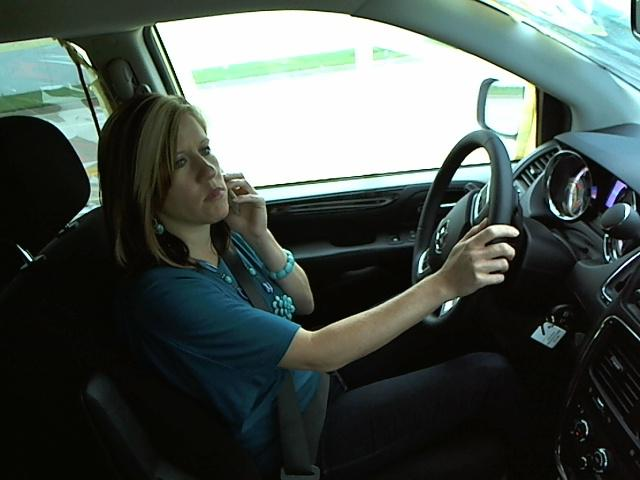

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c0; desc: normal driving; proba: 0.2903; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_97969.jpg:


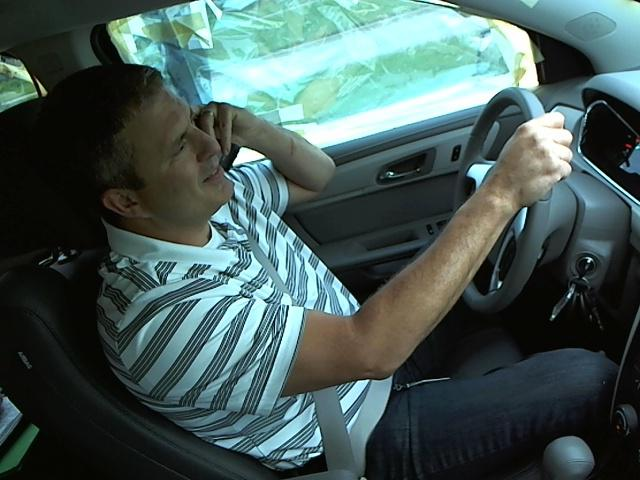

  Proba:
[ 0.2903  0.      0.      0.      0.0039  0.1909  0.2371  0.2771  0.
  0.0005]
  next best class: reaching behind


Max Proba for cls: c1; desc: texting - right; proba: 1.0000; nObsNew: 1155
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100237.jpg:


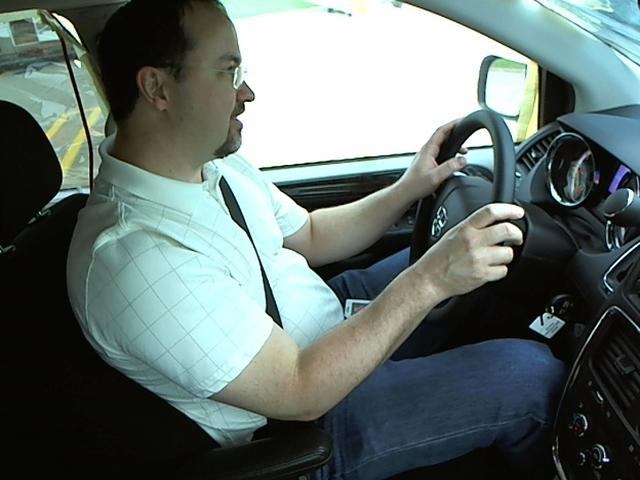

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c1; desc: texting - right; proba: 0.2943; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_7639.jpg:


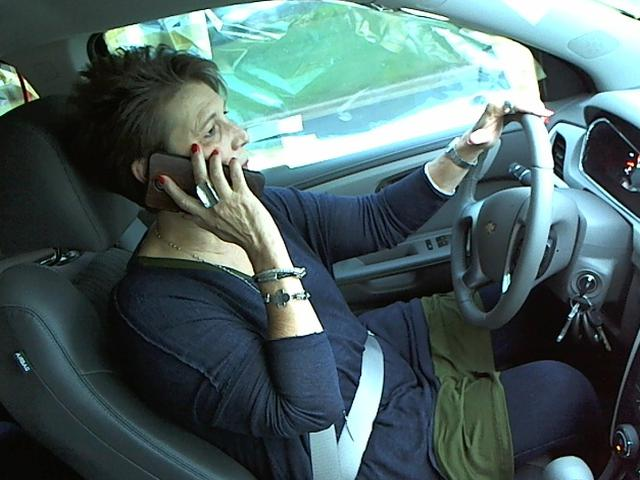

  Proba:
[ 0.0631  0.2943  0.0603  0.      0.      0.0499  0.      0.2776  0.2176
  0.0372]
  next best class: reaching behind


Max Proba for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObsNew: 103
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_102143.jpg:


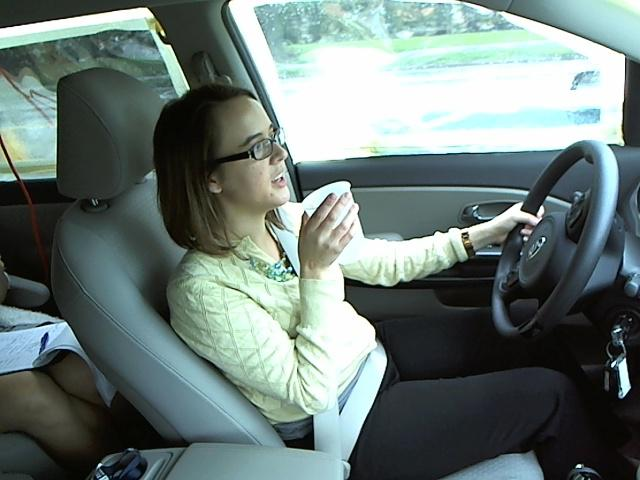

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c2; desc: talking on the phone - right; proba: 0.2704; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_72568.jpg:


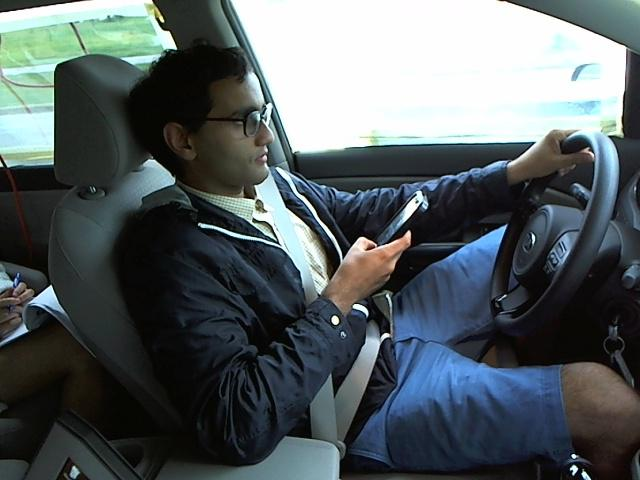

  Proba:
[ 0.2222  0.      0.2704  0.      0.      0.112   0.0697  0.1179  0.2074
  0.0004]
  next best class: normal driving


Max Proba for cls: c3; desc: texting - left; proba: 1.0000; nObsNew: 443
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100267.jpg:


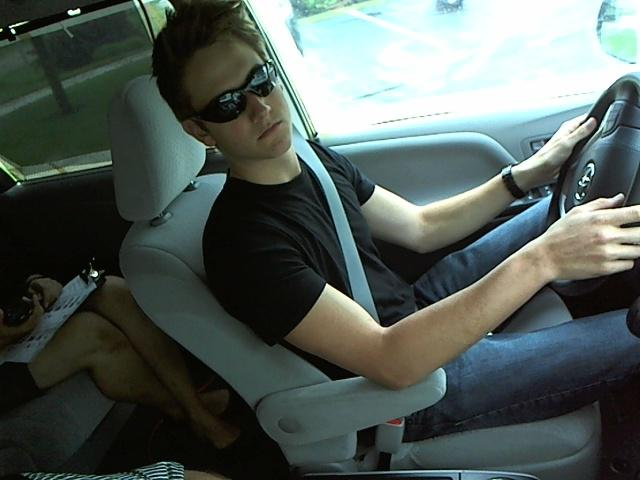

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c3; desc: texting - left; proba: 0.2650; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_78462.jpg:


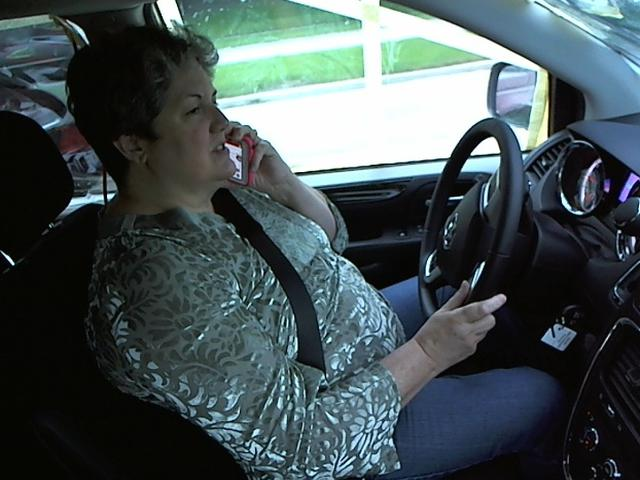

  Proba:
[ 0.238   0.2522  0.004   0.265   0.0582  0.0006  0.0678  0.0001  0.1022
  0.0118]
  next best class: texting - right


Max Proba for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObsNew: 323
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100389.jpg:


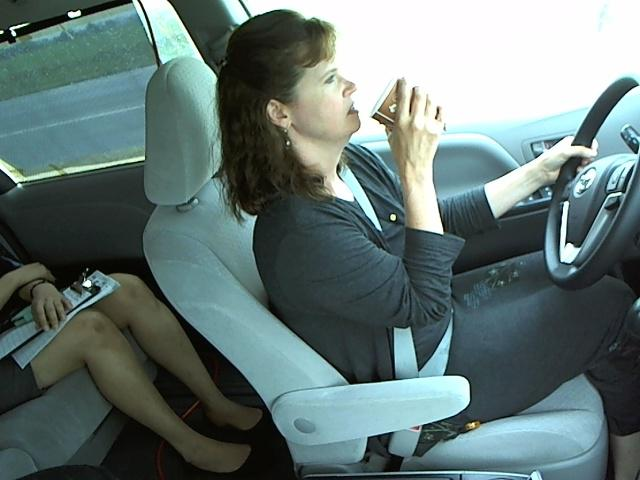

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
Min Proba for cls: c4; desc: talking on the phone - left; proba: 0.2608; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_75682.jpg:


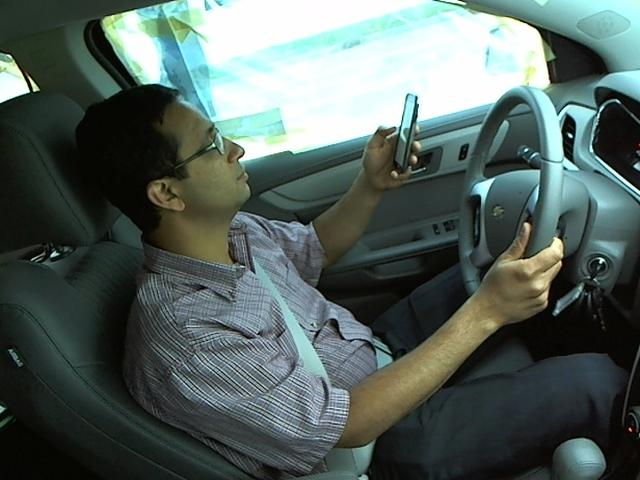

  Proba:
[ 0.1425  0.0001  0.2194  0.1448  0.2608  0.2171  0.0149  0.      0.
  0.0004]
  next best class: talking on the phone - right


Max Proba for cls: c5; desc: operating the radio; proba: 1.0000; nObsNew: 6766
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_1.jpg:


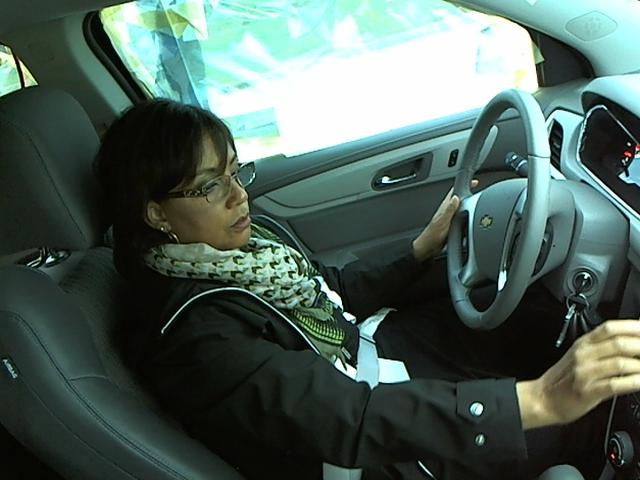

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
Min Proba for cls: c5; desc: operating the radio; proba: 0.2664; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_70199.jpg:


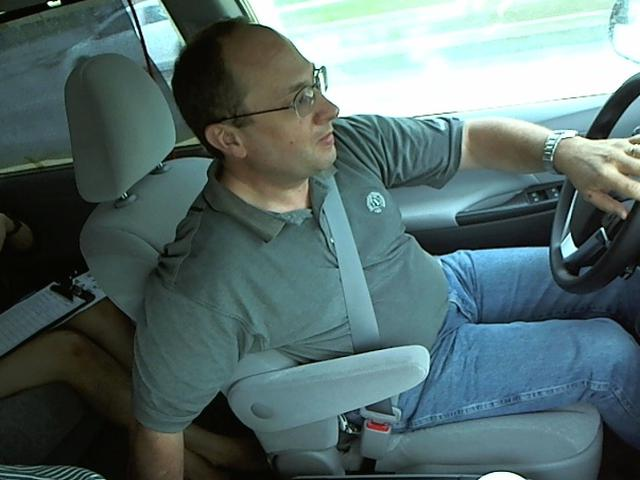

  Proba:
[ 0.2057  0.013   0.1844  0.005   0.0783  0.2664  0.0009  0.      0.0546
  0.1917]
  next best class: normal driving


Max Proba for cls: c6; desc: drinking; proba: 1.0000; nObsNew: 802
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100101.jpg:


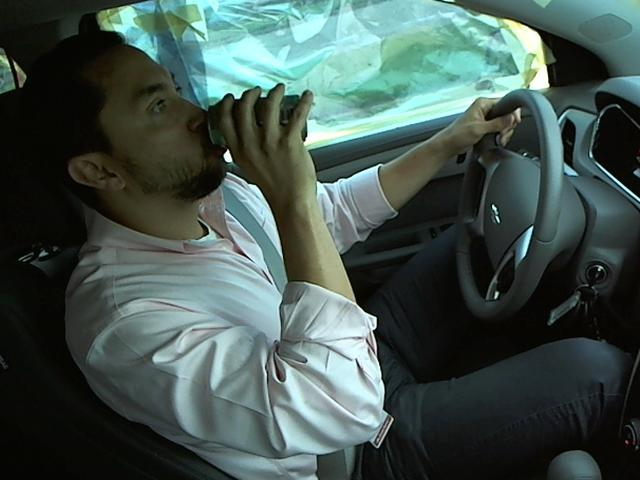

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
Min Proba for cls: c6; desc: drinking; proba: 0.3023; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_33565.jpg:


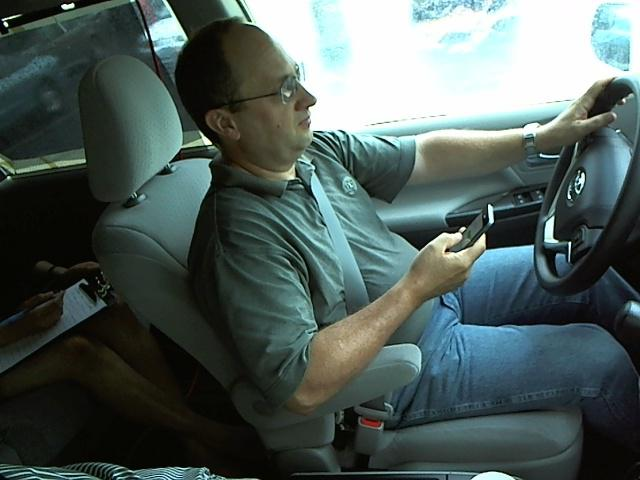

  Proba:
[ 0.1844  0.2949  0.1975  0.0005  0.      0.0045  0.3023  0.      0.0149
  0.0009]
  next best class: texting - right


Max Proba for cls: c7; desc: reaching behind; proba: 1.0000; nObsNew: 1979
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100005.jpg:


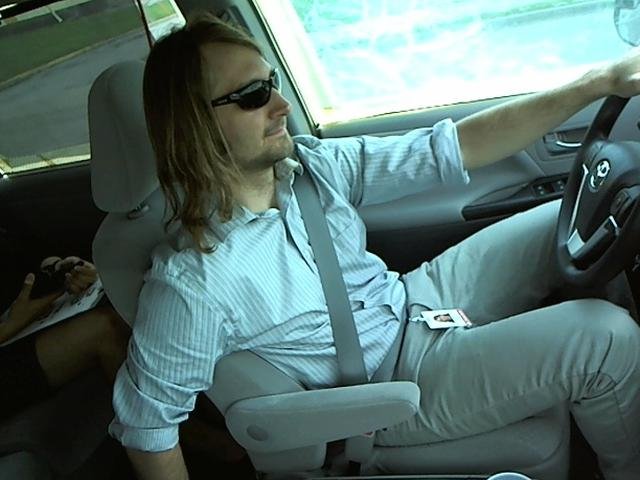

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
Min Proba for cls: c7; desc: reaching behind; proba: 0.2298; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100234.jpg:


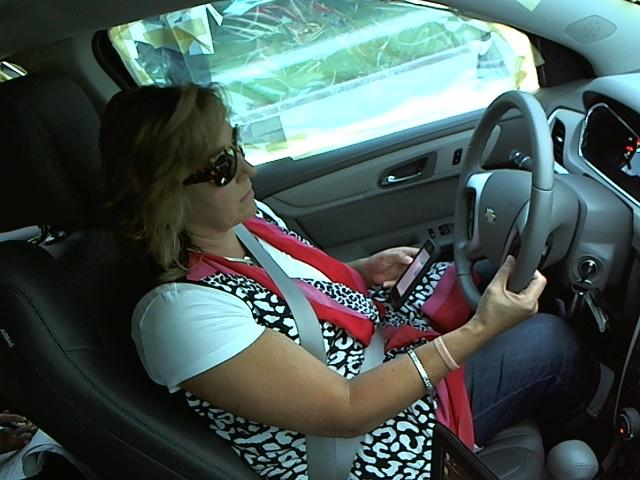

  Proba:
[ 0.2172  0.0971  0.0666  0.1792  0.1289  0.0343  0.0439  0.2298  0.0001
  0.0029]
  next best class: normal driving


Max Proba for cls: c8; desc: hair and makeup; proba: 1.0000; nObsNew: 808
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100102.jpg:


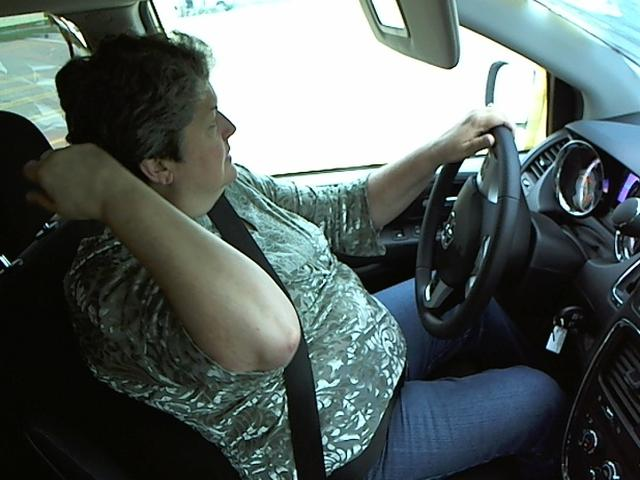

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
Min Proba for cls: c8; desc: hair and makeup; proba: 0.2732; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_13643.jpg:


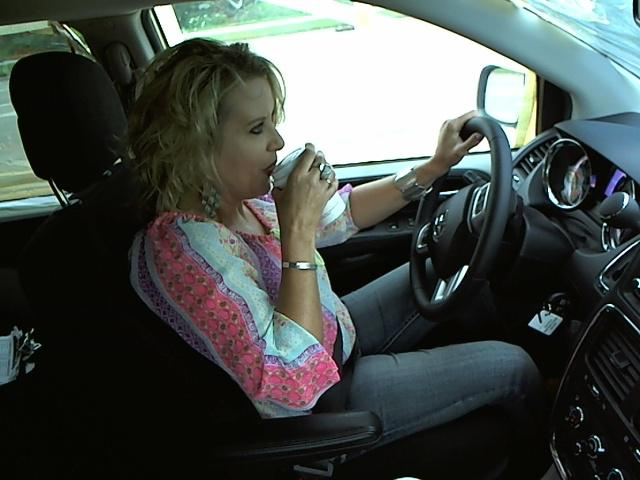

  Proba:
[ 0.1592  0.0161  0.0912  0.0007  0.2385  0.016   0.1044  0.0898  0.2732
  0.0109]
  next best class: talking on the phone - left


Max Proba for cls: c9; desc: talking to passenger; proba: 1.0000; nObsNew: 596
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100473.jpg:


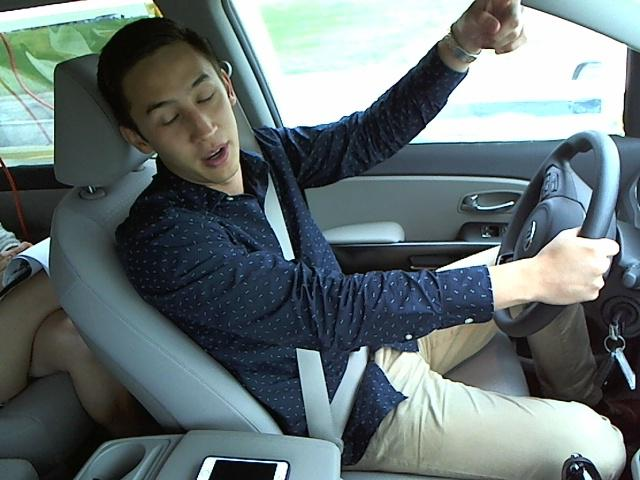

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
Min Proba for cls: c9; desc: talking to passenger; proba: 0.2747; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_58871.jpg:


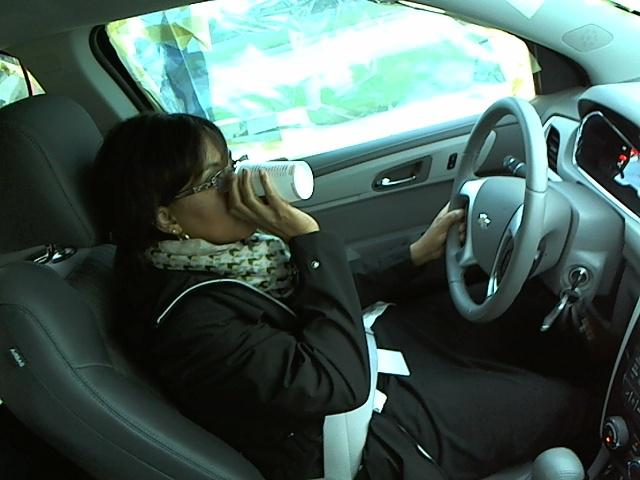

  Proba:
[ 0.0001  0.      0.0545  0.0772  0.2322  0.0032  0.0431  0.055   0.2601
  0.2747]
  next best class: hair and makeup


In [193]:
def mydspObsNewPredictions(lclObsNewRspPredProba):
    for clsIx, cls in enumerate(glbRspClass):
        clsMsk = (np.argmax(lclObsNewRspPredProba, axis = 1) == clsIx)
        clsObsNewRspPredProba = lclObsNewRspPredProba[clsMsk, :]
        clsObsNewIdn = [glbObsNewIdn[ixMsk] for ixMsk in xrange(len(glbObsNewIdn)) \
                        if clsMsk[ixMsk]]
        print '\n'

        maxClsProba = np.max(clsObsNewRspPredProba[:, clsIx])
        maxObsNewRspPredProba = clsObsNewRspPredProba[:, clsIx] == maxClsProba
        print 'Max Proba for cls: %s; desc: %s; proba: %0.4f; nObsNew: %d' % \
            (cls, glbRspClassDesc[cls], maxClsProba, maxObsNewRspPredProba.sum())
        imgFilePth = os.getcwd() + '/data/' + glbDataFile['newFoldersPth'] + '/' + \
                        clsObsNewIdn[np.argmax(clsObsNewRspPredProba[:, clsIx])]
        print '  %s:' % imgFilePth
        jpgfile = Image(imgFilePth, format = 'jpg', 
                            width = glbImg['size'] * 4, height = glbImg['size'] * 4)
        display(jpgfile)         
        print '  Proba:'; 
        print np.array_str(clsObsNewRspPredProba[np.argmax(clsObsNewRspPredProba[:, clsIx]), :],
                           precision=4, suppress_small=True)

        minClsProba = np.min(clsObsNewRspPredProba[:, clsIx])
        minObsNewRspPredProba = clsObsNewRspPredProba[:, clsIx] == minClsProba
        print 'Min Proba for cls: %s; desc: %s; proba: %0.4f; nObsNew: %d' % \
            (cls, glbRspClassDesc[cls], minClsProba, minObsNewRspPredProba.sum())
        imgFilePth = os.getcwd() + '/data/' + glbDataFile['newFoldersPth'] + '/' + \
                        clsObsNewIdn[np.argmin(clsObsNewRspPredProba[:, clsIx])]
        print '  %s:' % imgFilePth
        jpgfile = Image(imgFilePth, format = 'jpg', 
                            width = glbImg['size'] * 4, height = glbImg['size'] * 4)
        display(jpgfile)
        print '  Proba:'; 
        print np.array_str(clsObsNewRspPredProba[np.argmin(clsObsNewRspPredProba[:, clsIx]), :],
                           precision=4, suppress_small=True)
        thsObsNewRspPredProba = clsObsNewRspPredProba[np.argmin(clsObsNewRspPredProba[:, clsIx]), :]
        thsObsNewRspPredProba[clsIx] = 0
        print '  next best class: %s' % \
            (glbRspClassDesc[glbRspClass[np.argmax(thsObsNewRspPredProba)]])
            
print '=========================='
print 'selMdl ObsNewRspPredProba:'
mydspObsNewPredictions(selObsNewRspPredProba)            

finMdl ObsNewRspPredProba:


Max Proba for cls: c0; desc: normal driving; proba: 1.0000; nObsNew: 468
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100405.jpg:


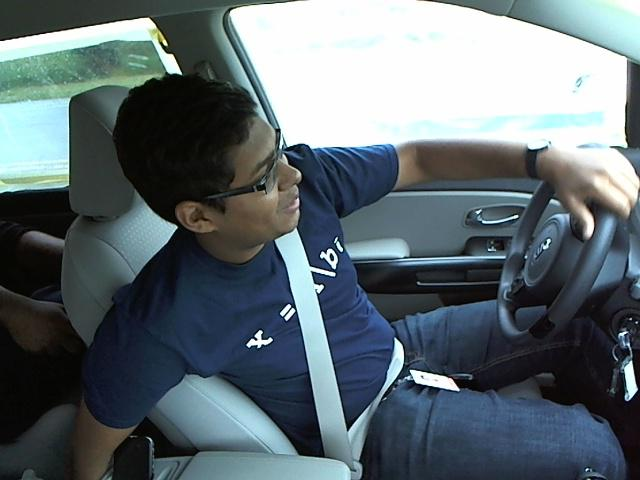

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c0; desc: normal driving; proba: 0.2220; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_28255.jpg:


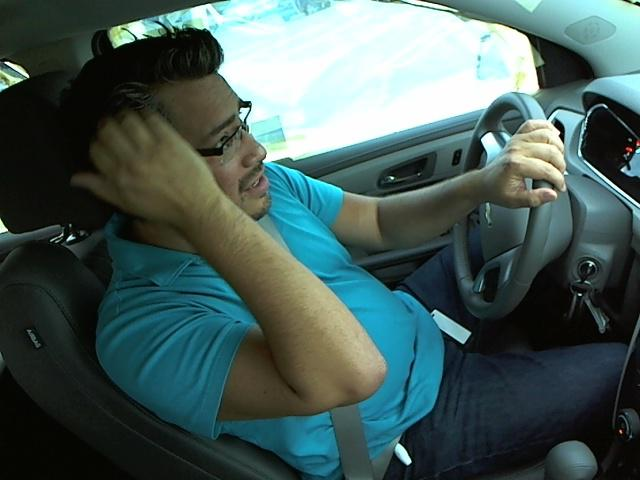

  Proba:
[ 0.222   0.066   0.0755  0.1031  0.1757  0.1357  0.1965  0.0227  0.0007
  0.0022]
  next best class: drinking


Max Proba for cls: c1; desc: texting - right; proba: 1.0000; nObsNew: 470
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100351.jpg:


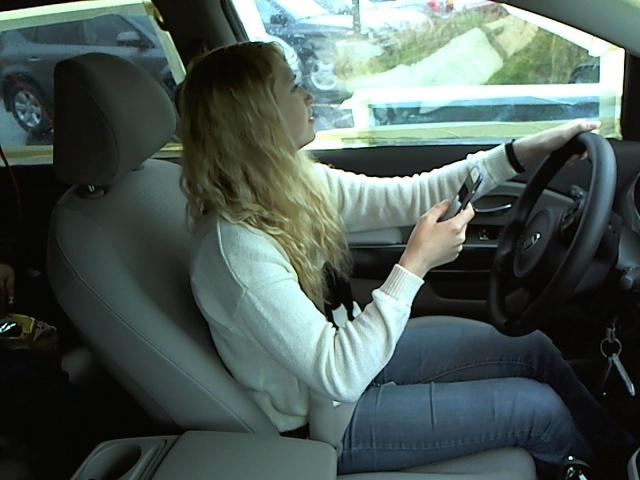

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c1; desc: texting - right; proba: 0.2823; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_77037.jpg:


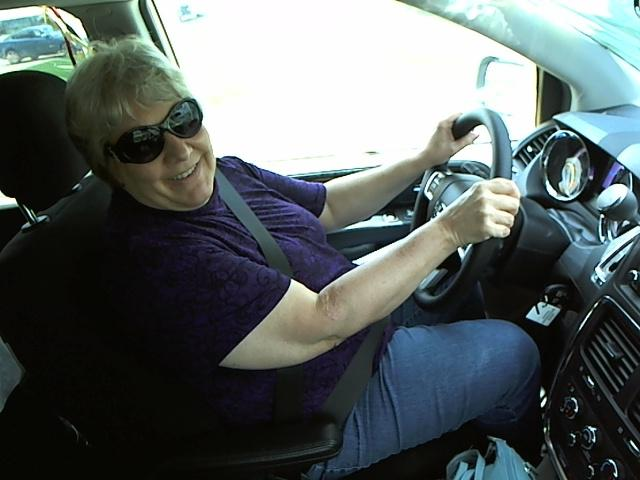

  Proba:
[ 0.1412  0.2823  0.2474  0.      0.      0.0049  0.0272  0.2657  0.
  0.0314]
  next best class: reaching behind


Max Proba for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObsNew: 79
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100321.jpg:


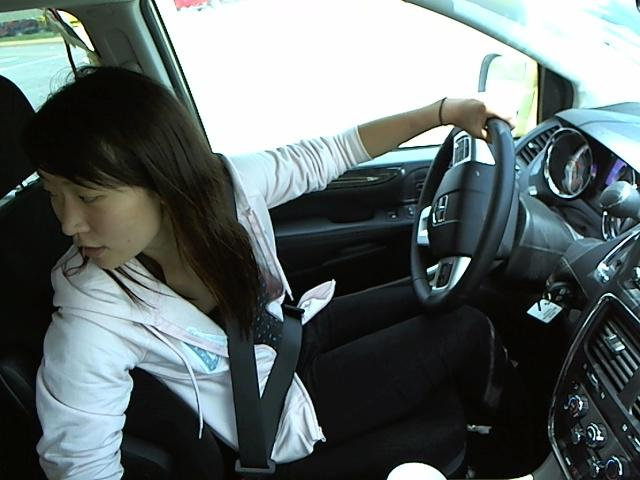

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c2; desc: talking on the phone - right; proba: 0.2314; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_63850.jpg:


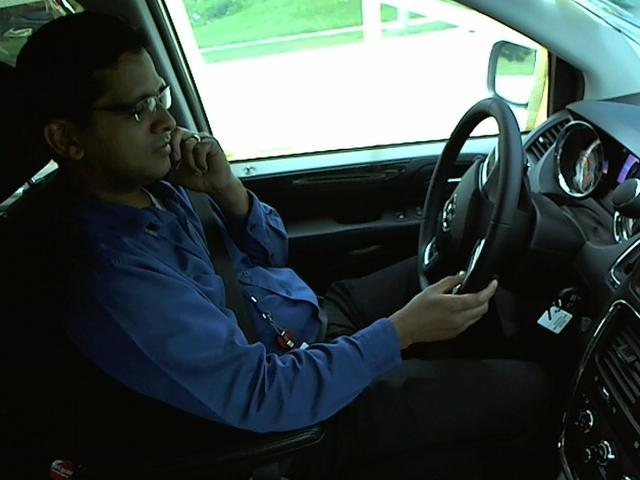

  Proba:
[ 0.1195  0.0296  0.2314  0.1934  0.2232  0.0097  0.0622  0.0886  0.0396
  0.0029]
  next best class: talking on the phone - left


Max Proba for cls: c3; desc: texting - left; proba: 1.0000; nObsNew: 313
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100302.jpg:


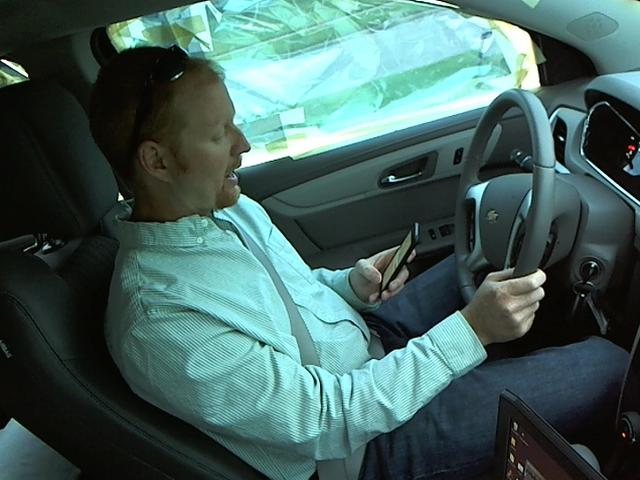

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c3; desc: texting - left; proba: 0.2471; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_55940.jpg:


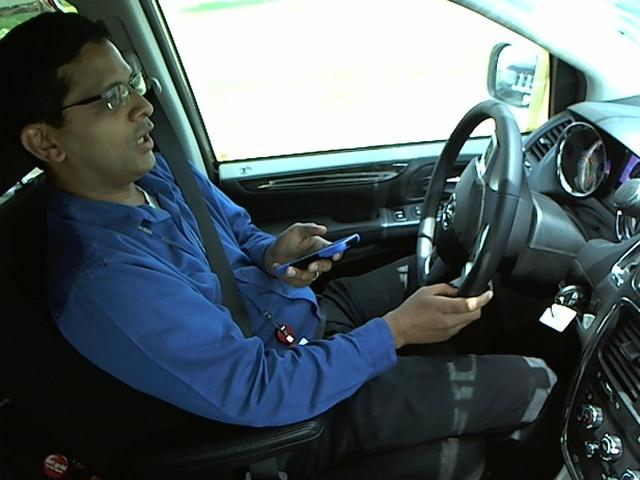

  Proba:
[ 0.1174  0.1489  0.0014  0.2471  0.0655  0.      0.0019  0.2246  0.1901
  0.0031]
  next best class: reaching behind


Max Proba for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObsNew: 493
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100262.jpg:


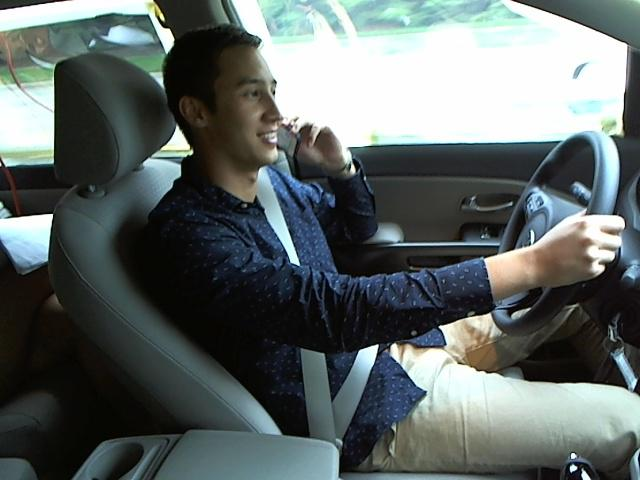

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
Min Proba for cls: c4; desc: talking on the phone - left; proba: 0.2476; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_9854.jpg:


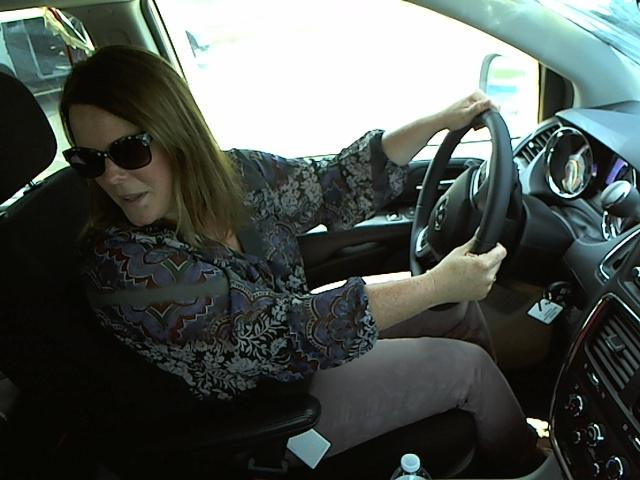

  Proba:
[ 0.2394  0.2402  0.1     0.0208  0.2476  0.0005  0.0871  0.008   0.0025
  0.0539]
  next best class: texting - right


Max Proba for cls: c5; desc: operating the radio; proba: 1.0000; nObsNew: 4624
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_1.jpg:


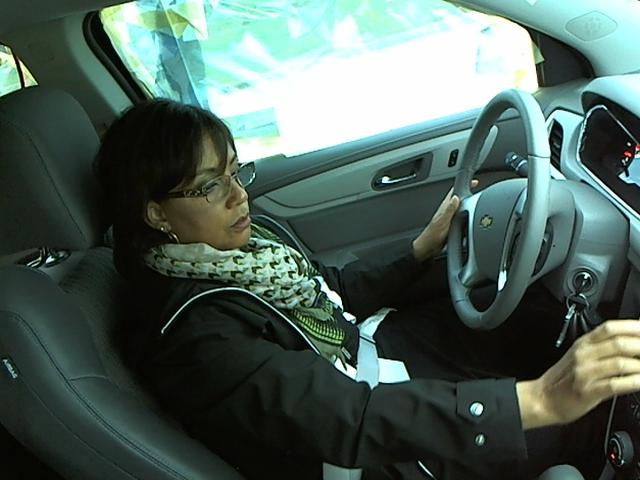

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
Min Proba for cls: c5; desc: operating the radio; proba: 0.2260; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_50376.jpg:


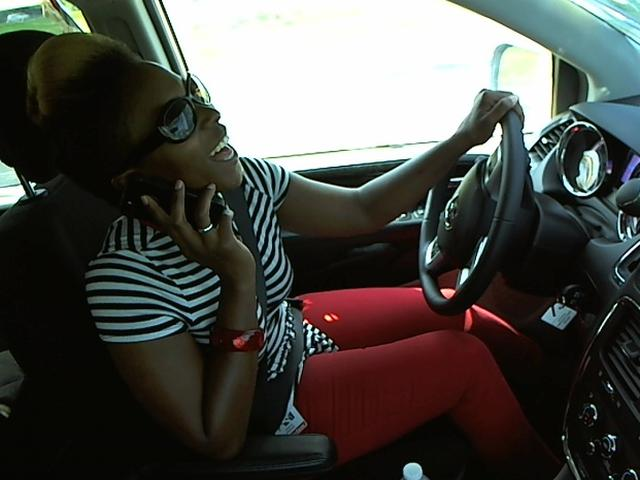

  Proba:
[ 0.2108  0.0901  0.0096  0.0024  0.1577  0.226   0.0001  0.2051  0.
  0.0983]
  next best class: normal driving


Max Proba for cls: c6; desc: drinking; proba: 1.0000; nObsNew: 746
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100214.jpg:


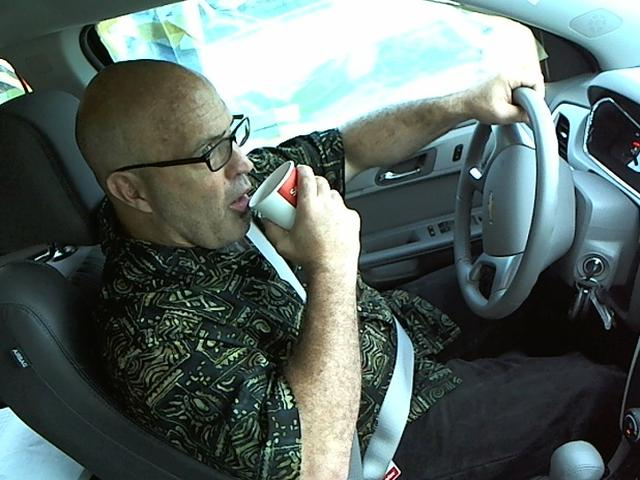

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
Min Proba for cls: c6; desc: drinking; proba: 0.2840; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_43327.jpg:


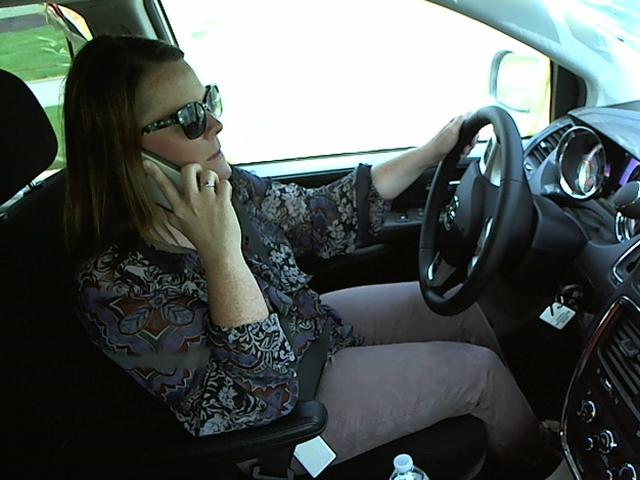

  Proba:
[ 0.0351  0.2511  0.0135  0.      0.0376  0.      0.284   0.2005  0.0449
  0.1333]
  next best class: texting - right


Max Proba for cls: c7; desc: reaching behind; proba: 1.0000; nObsNew: 2265
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100005.jpg:


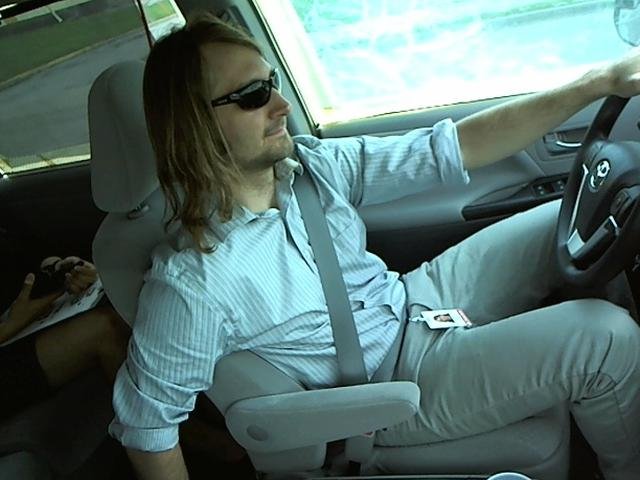

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
Min Proba for cls: c7; desc: reaching behind; proba: 0.2362; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_94383.jpg:


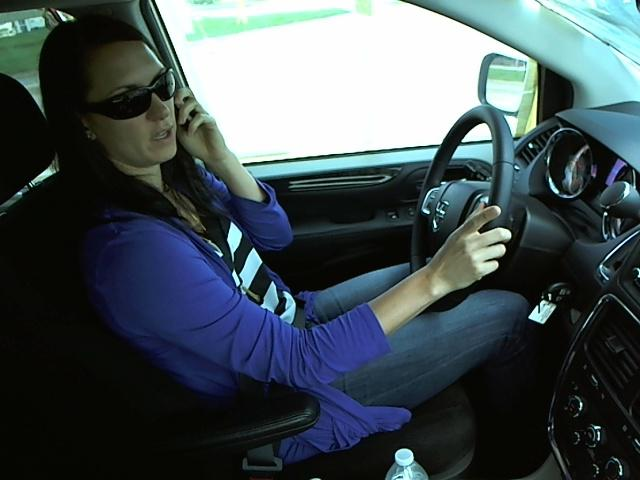

  Proba:
[ 0.1885  0.216   0.0945  0.1194  0.0698  0.0003  0.0001  0.2362  0.0252
  0.0499]
  next best class: texting - right


Max Proba for cls: c8; desc: hair and makeup; proba: 1.0000; nObsNew: 534
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100040.jpg:


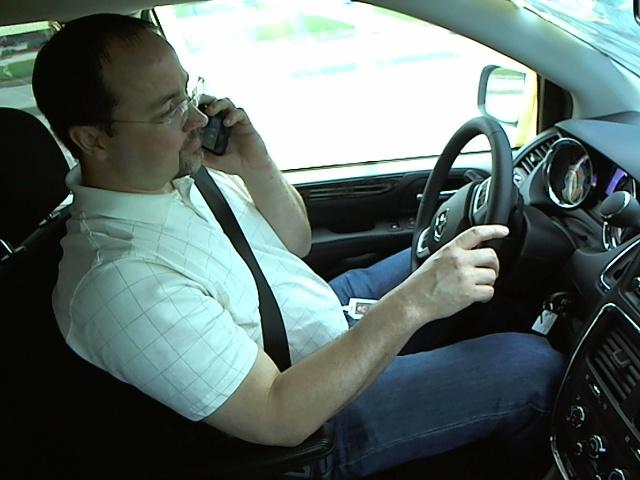

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
Min Proba for cls: c8; desc: hair and makeup; proba: 0.2709; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_49667.jpg:


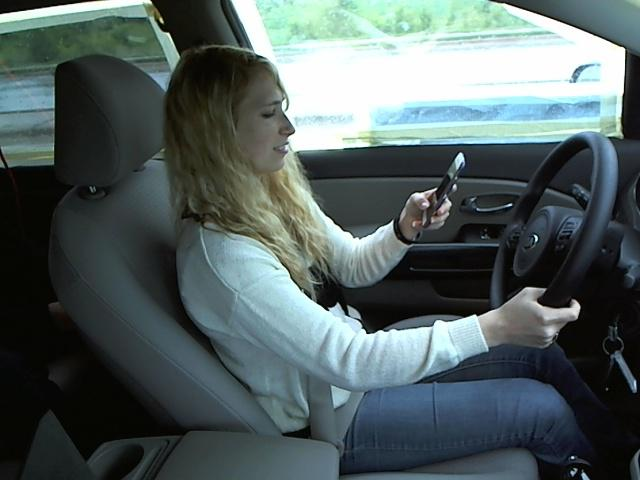

  Proba:
[ 0.      0.1677  0.1642  0.0001  0.      0.0001  0.      0.2404  0.2709
  0.1567]
  next best class: reaching behind


Max Proba for cls: c9; desc: talking to passenger; proba: 1.0000; nObsNew: 602
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100473.jpg:


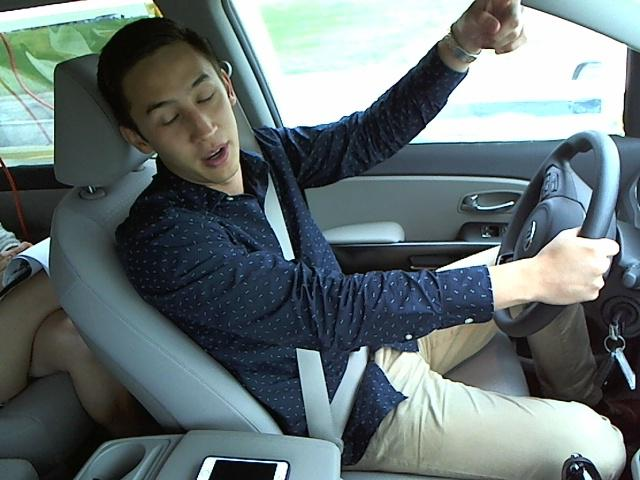

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
Min Proba for cls: c9; desc: talking to passenger; proba: 0.2781; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_56307.jpg:


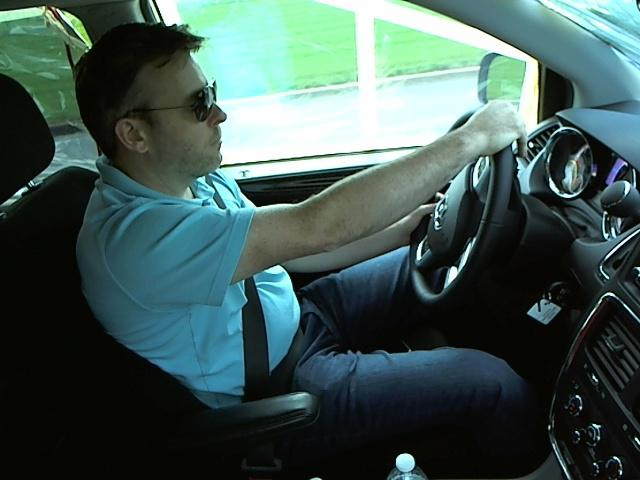

  Proba:
[ 0.2559  0.0036  0.0002  0.029   0.0016  0.0001  0.0001  0.1569  0.2746
  0.2781]
  next best class: hair and makeup


In [194]:
print '=========================='
print 'finMdl ObsNewRspPredProba:'
mydspObsNewPredictions(finObsNewRspPredProba)

### Differences between selObsNewRspPredProba &  finObsNewRspPredProba

                 idn    idx  proba.dff.abs.cls.sum
16452     img_27.jpg  16452                    2.0
11517  img_21314.jpg  11517                    2.0
42607  img_57204.jpg  42607                    2.0
60631  img_78029.jpg  60631                    2.0
5394   img_14253.jpg   5394                    2.0
51619    img_676.jpg  51619                    2.0
25589  img_37616.jpg  25589                    2.0
67176  img_85535.jpg  67176                    2.0
67204  img_85569.jpg  67204                    2.0
44545  img_59477.jpg  44545                    2.0

  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_27.jpg:


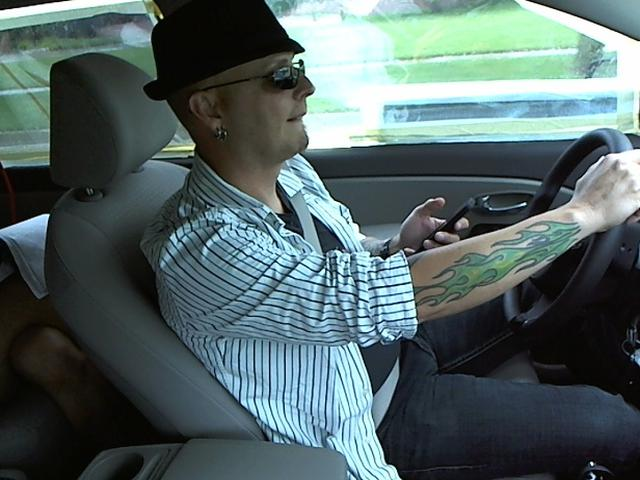

Sel Proba for cls: 1; desc: texting - right; proba: 1.0000
Fin Proba for cls: 3; desc: texting - left; proba: 1.0000

  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_21314.jpg:


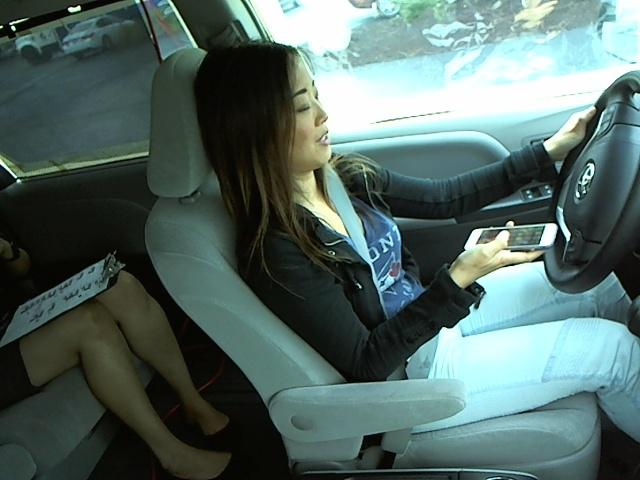

Sel Proba for cls: 5; desc: operating the radio; proba: 1.0000
Fin Proba for cls: 0; desc: normal driving; proba: 0.9998

  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_57204.jpg:


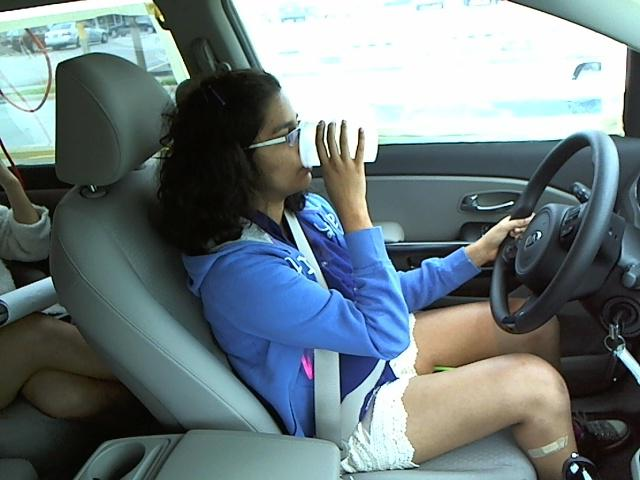

Sel Proba for cls: 7; desc: reaching behind; proba: 0.9132
Fin Proba for cls: 6; desc: drinking; proba: 1.0000

  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_78029.jpg:


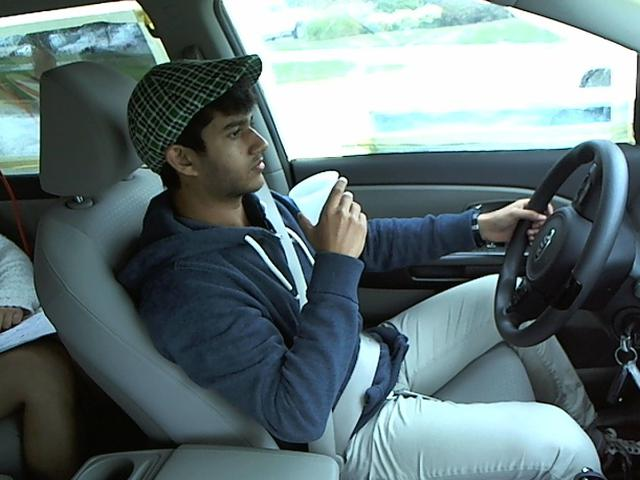

Sel Proba for cls: 5; desc: operating the radio; proba: 1.0000
Fin Proba for cls: 1; desc: texting - right; proba: 0.9292

  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_14253.jpg:


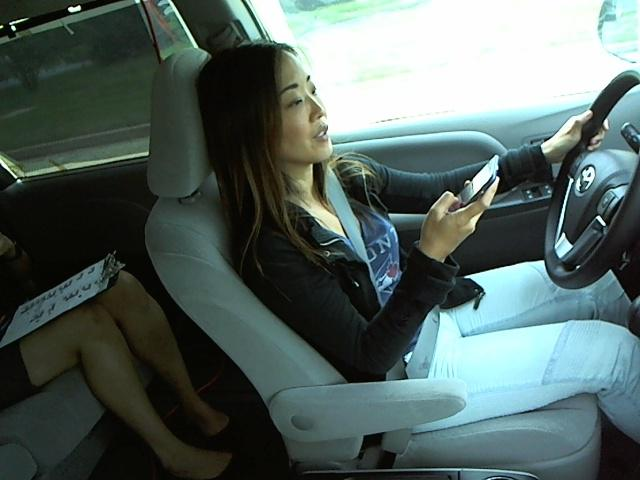

Sel Proba for cls: 5; desc: operating the radio; proba: 1.0000
Fin Proba for cls: 0; desc: normal driving; proba: 0.9995

  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_676.jpg:


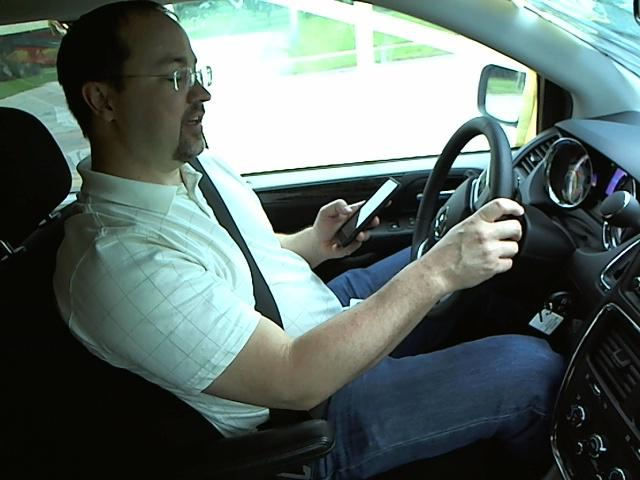

Sel Proba for cls: 1; desc: texting - right; proba: 1.0000
Fin Proba for cls: 5; desc: operating the radio; proba: 0.9996

  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_37616.jpg:


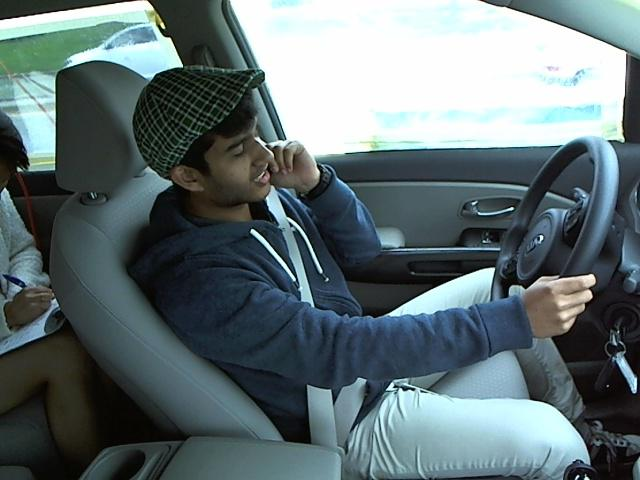

Sel Proba for cls: 5; desc: operating the radio; proba: 1.0000
Fin Proba for cls: 9; desc: talking to passenger; proba: 0.9999

  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_85535.jpg:


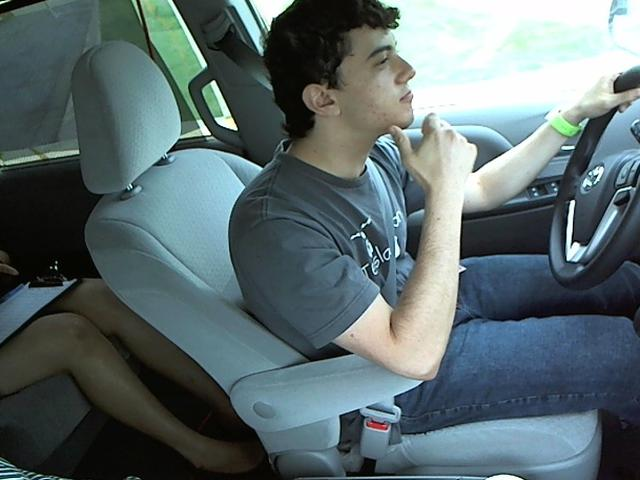

Sel Proba for cls: 1; desc: texting - right; proba: 1.0000
Fin Proba for cls: 4; desc: talking on the phone - left; proba: 1.0000

  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_85569.jpg:


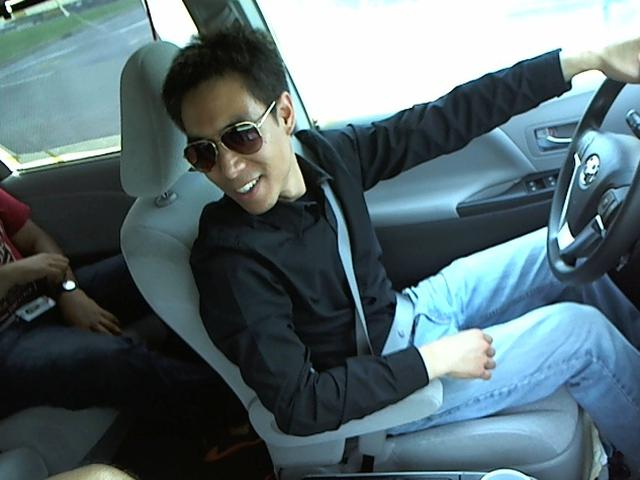

Sel Proba for cls: 9; desc: talking to passenger; proba: 1.0000
Fin Proba for cls: 7; desc: reaching behind; proba: 0.9994

  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_59477.jpg:


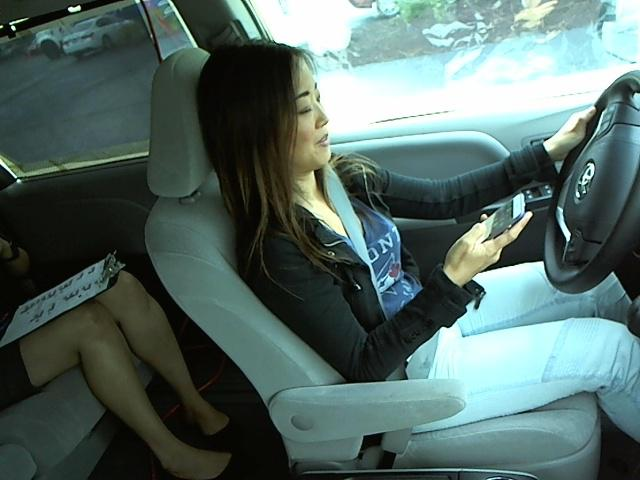

Sel Proba for cls: 5; desc: operating the radio; proba: 1.0000
Fin Proba for cls: 0; desc: normal driving; proba: 1.0000


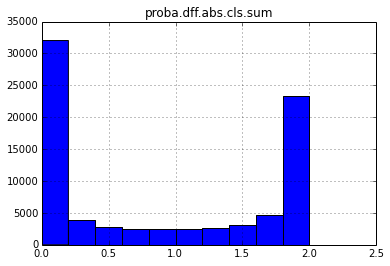

In [219]:
finSelProbaDffAbs = abs(finObsNewRspPredProba - selObsNewRspPredProba)
# print np.array_str(finSelProbaDffAbs[0:6, :], 
#                    precision = 4, suppress_small = True)
finSelProbaDffAbsObsSum = np.sum(finSelProbaDffAbs, axis = 1)
# print finSelProbaDffAbsObsSum.shape
# print np.array_str(finSelProbaDffAbsObsSum[0:6], 
#                    precision = 4, suppress_small = True)
finSelDf = pd.DataFrame({
        'idx': range(glbObsNewRsp.shape[0]),
        'idn': glbObsNewIdn,
        'proba.dff.abs.cls.sum' : finSelProbaDffAbsObsSum
    })
# print finSelDf[:6]
finSelDf = finSelDf.sort_values('proba.dff.abs.cls.sum', ascending = False)
finSelDf.hist('proba.dff.abs.cls.sum')
print finSelDf[:10]

for ix in xrange(10):
    imgFilePth = os.getcwd() + '/data/' + glbDataFile['newFoldersPth'] + '/' + \
                        glbObsNewIdn[finSelDf.iloc[ix]['idx']]
    print '\n  %s:' % imgFilePth    
    jpgfile = Image(imgFilePth, format = 'jpg', 
                    width = glbImg['size'] * 4, height = glbImg['size'] * 4)
    display(jpgfile)
    
#     print finSelDf.ix[ix]['idx']
    selCls = np.argmax(selObsNewRspPredProba[finSelDf.iloc[ix]['idx'], :])
#     print selCls
#     print glbRspClassDesc['c' + str(selCls)]
#     print np.max(selObsNewRspPredProba[finSelDf.ix[ix]['idx'], :])    
    print 'Sel Proba for cls: %s; desc: %s; proba: %0.4f' % \
            (selCls, glbRspClassDesc['c' + str(selCls)], 
             np.max(selObsNewRspPredProba[finSelDf.iloc[ix]['idx'], :]))
        
    finCls = np.argmax(finObsNewRspPredProba[finSelDf.iloc[ix]['idx'], :])
    print 'Fin Proba for cls: %s; desc: %s; proba: %0.4f' % \
            (finCls, glbRspClassDesc['c' + str(finCls)], 
             np.max(finObsNewRspPredProba[finSelDf.iloc[ix]['idx'], :]))        

## Output submission

In [221]:
def myoutputSubmission(lclObsNewRspPredProba, fileName):
    sbmObsNewDf = pd.DataFrame(lclObsNewRspPredProba)
    sbmObsNewDf.columns = glbRspClass
    sbmObsNewDf['img'] = glbObsNewIdn
    sbmObsNewDf = (sbmObsNewDf
                    .set_index(['img'], 
                               drop = False)
                    .sort_values('img')
                    )
    sbmObsNewDf = sbmObsNewDf[['img'] + glbRspClass]
    print sbmObsNewDf.head()
    print sbmObsNewDf.tail()
    
    print '\nexporting %d rows to %s...' % (sbmObsNewDf.shape[0], 
                                         fileName)
    sbmObsNewDf.to_csv(fileName, index = False)
    
myoutputSubmission(selObsNewRspPredProba, 
                  'img_05_fit_MLP_RELU_SGD_Tf_Sel_SFDD_sbmt.csv')    

                           img            c0            c1            c2  \
img                                                                        
img_1.jpg            img_1.jpg  9.857017e-18  4.961295e-20  1.742225e-18   
img_10.jpg          img_10.jpg  7.533770e-19  1.127235e-20  1.007804e-23   
img_100.jpg        img_100.jpg  6.013104e-07  2.115661e-02  1.579570e-04   
img_1000.jpg      img_1000.jpg  2.475477e-04  1.370030e-07  6.258654e-04   
img_100000.jpg  img_100000.jpg  3.688781e-19  1.334809e-22  5.221433e-29   

                          c3            c4        c5            c6  \
img                                                                  
img_1.jpg       2.340969e-26  1.404270e-19  1.000000  2.032494e-14   
img_10.jpg      2.893077e-15  3.038766e-20  1.000000  0.000000e+00   
img_100.jpg     8.905653e-01  8.135698e-07  0.059100  3.601568e-04   
img_1000.jpg    8.330435e-10  4.184684e-07  0.000067  9.953246e-01   
img_100000.jpg  1.414894e-29  9.999584e-01  0.0

In [222]:
myoutputSubmission(finObsNewRspPredProba, 
                  'img_05_fit_MLP_RELU_SGD_Tf_Fin_SFDD_sbmt.csv')    

                           img            c0            c1            c2  \
img                                                                        
img_1.jpg            img_1.jpg  2.173698e-27  2.121494e-23  1.343665e-18   
img_10.jpg          img_10.jpg  1.408802e-01  5.544424e-11  3.539516e-22   
img_100.jpg        img_100.jpg  9.995050e-01  1.954394e-06  3.757028e-15   
img_1000.jpg      img_1000.jpg  3.713972e-04  2.250629e-07  5.969376e-01   
img_100000.jpg  img_100000.jpg  9.470202e-15  3.550937e-24  3.490162e-20   

                          c3            c4            c5            c6  \
img                                                                      
img_1.jpg       6.523967e-26  5.294976e-17  1.000000e+00  7.106607e-12   
img_10.jpg      3.802502e-02  9.656075e-22  8.463988e-06  5.925507e-25   
img_100.jpg     9.327260e-08  1.164758e-05  5.509713e-05  1.210192e-13   
img_1000.jpg    1.469364e-10  1.266351e-07  2.466014e-07  1.323776e-01   
img_100000.jpg  7.07400

In [224]:
print 'LeaderBoard metric for this Sel submission: %0.5f' % (9.49682)
print 'LeaderBoard metric for this Fin submission: %0.5f' % (9.48230)
print 'Best score yet:%s: %0.5f' % \
    ('img_02_fit_lgtRgr_SFDD_sbmt.csv', 2.63892)

LeaderBoard metric for this Sel submission: 9.49682
LeaderBoard metric for this Fin submission: 9.48230
Best score yet:img_02_fit_lgtRgr_SFDD_sbmt.csv: 2.63892


## Stop here

Following code should be in img_**_fit_MLP_RELU_SGD_Tf_<projectId> ???

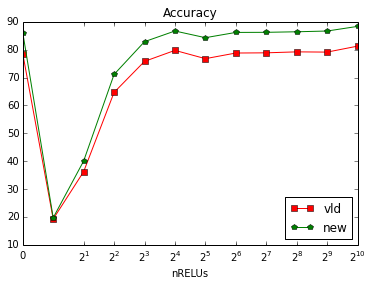

In [52]:
plt.figure()
#plt.plot(models['nRELUs'], models['accuracy_score.fit'], 'bo-', label = 'fit')
plt.plot(models['nRELUs'], models['accuracy_scoreVld'], 'rs-', label = 'vld')
plt.plot(models['nRELUs'], models['accuracy_scoreTst'], 'gp-', label = 'new')
plt.legend(loc = 'lower right')
plt.title("accuracy_score")
plt.xscale('symlog', basex=2)
axes = plt.gca()
axes.set_xlabel('nRELUs')
# axes.set_xlim([mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] / 10 ** 2, \
#                mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] * 10 ** 2])
# axes.set_ylim([0, mdlDF['RSS.vld'].min() * 1.5])
plt.show()